# Making Paper Figures
This notebook compares is based off of `analysis/object_vs_meta_comparisions.ipynb`

It creates three figures for the paper.

In [ ]:
STUDY_FOLDERS = ["may20_thrifty_sweep"]  # 🔵 within exp/

CONDITIONS = {
    # see `analysis/loading_data.py` for details
    ("task", "set"): ["val"],
    # ("language_model","model"): ["gpt-4-0613","gpt-3.5-turbo-0125"],
    # ("task", "name"): [
    #     "daily_dialog",
    #     "english_words",
        # "wikipedia",
    #     "dear_abbie",
    #     "self_referential",
    # ],
}

In [ ]:
from pathlib import Path
import subprocess
import sys
import random
import logging
import io
import contextlib
from IPython.display import clear_output
import itertools

In [ ]:
# set log level
logging.basicConfig(level=logging.WARNING)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import words
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patches as patches
import seaborn as sns
import scipy.stats as stats
import tqdm
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
from evals.analysis.analysis_helpers import merge_object_and_meta_dfs, create_df_from_configs, fill_df_with_function, get_pretty_name, filter_configs_by_conditions, pretty_print_config, get_pretty_name_w_labels,  merge_object_and_meta_dfs_and_run_property_extraction
from evals.analysis.loading_data import load_dfs_with_filter, load_base_df_from_config, get_hydra_config, load_single_df, get_data_path
from evals.load.lazy_object_level_llm_extraction import lazy_add_response_property_to_object_level
from evals.utils import get_maybe_nested_from_dict
from evals.analysis.analysis_functions import *
from evals.analysis.analysis_helpers import bootstrap_ci

In [ ]:
# Set the display option to None to show all content
pd.set_option('display.max_colwidth', 200)
# show all columns
pd.set_option('display.max_columns', None)

In [ ]:
# set color palette
palette = sns.color_palette("Set1", 64)
sns.set_palette(palette)

In [ ]:
# do we have a nice font installed? You might need to clear the matplotlib font cache
plt.rcParams["font.family"] = fm.get_font(fm.findfont("Univers Next Pro")).family_name # falls back to default automatically

# retina plots
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
# get seaborn to shut up
import warnings
# Ignore the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [ ]:
from evals.locations import REPO_DIR, EXP_DIR

Load dataframes in

In [ ]:
# load the dataframes with configs as keys
dfs = {}
for STUDY_FOLDER in STUDY_FOLDERS:
    _dfs = load_dfs_with_filter(EXP_DIR / STUDY_FOLDER, CONDITIONS, exclude_noncompliant=False)
    dfs.update(_dfs)
    print(f"Loaded {len(_dfs)} dataframes from {STUDY_FOLDER}")
clear_output()
print(f"Loaded {len(dfs)} dataframes in total")

In [ ]:
def is_base_config(config):
    return config["prompt"]["method"].startswith("object") or config["prompt"]["method"].startswith("base")

In [ ]:
object_dfs = {config: df for config, df in dfs.items() if is_base_config(config)}
meta_dfs = {config: df for config, df in dfs.items() if not is_base_config(config)}
print(f"Loaded {len(object_dfs)} base and {len(meta_dfs)} self-prediction dataframes")

In [ ]:
print("We have the following datasets:")
datasets = set([get_maybe_nested_from_dict(k, ('task', 'name')) for k in object_dfs.keys()])
print(datasets)

In [ ]:
print("We have the following response properties:")
response_properties = set([get_maybe_nested_from_dict(k, ('response_property', 'name')) for k in meta_dfs.keys()])
print(response_properties)

load non-determinism ceiling (see `side_experiments/compute_nondeterminism_ceiling_for_sweep.ipynb`)

In [ ]:
assert len(STUDY_FOLDERS) == 1, "This notebook only supports one study folder at a time"

In [ ]:
try:
    non_determinism_ceiling = pd.read_csv(EXP_DIR / "nondeterminism_ceiling" / f"{STUDY_FOLDERS[0]}_ceiling_pair_results.csv")
    print(f"Loaded non-determinism ceiling data with {len(non_determinism_ceiling)} rows")
except FileNotFoundError:
    print("No non-determinism ceiling data found")
    print("Using empty dummy data")
    non_determinism_ceiling = pd.DataFrame(columns=['modelA', 'modelB', 'task', 'response_property', 'ceiling', 'ci'])

In [ ]:
non_determinism_ceiling

In [ ]:
# assert that for each model we have the correspoding entry here
found_models = set()
for cfg in dfs.keys():
    model = get_maybe_nested_from_dict(cfg, ('language_model', 'model'))
    if not model in non_determinism_ceiling["modelA"].values and not model in found_models:
        print(f"Missing model {model} in non-determinism ceiling data")
        found_models.add(model)

## Plots

### Making labels

In [ ]:
def get_label(config):
    try: # if we just pass the model name in, we can skip the rest
        return MODEL_LABELS[config]
    except KeyError:
        pass
    try:
        label = ""
        if isinstance(config, str):
            config = eval(config)
        model = get_maybe_nested_from_dict(config, ('language_model', 'model'))
        if model in MODEL_LABELS:
            model = MODEL_LABELS[model]
        label += model
        response_property = get_maybe_nested_from_dict(config, ('response_property', 'name'))
        if response_property not in ["None", None]:
            label += f"\n predicting {response_property}"
        note = get_maybe_nested_from_dict(config, 'note')
        if note not in ["None", None]:
            label += f"\n{note}"
    except Exception as e:
        print(f"Failed to get label for {config}: {e}")
        label = str(config)
    return label

In [ ]:
MODEL_LABELS = {
    "gpt-3.5-turbo-1106": "GPT3.5 (1106)",
    "gpt-3.5-turbo-0125": "GPT3.5",
    "gpt-4-0613": "GPT4",
    "gpt-4-0125-preview": "GPT4 preview",
    "claude-3-sonnet-20240229": "Claude 3 Sonnet",
    "claude-3-opus-20240229": "Claude 3 Opus",
    "gemini-1.0-pro-002": "Gemini 1.0 Pro",
    # some finetune
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:35on35onnum:8x4lehAb": "GPT3.5 fted on GPT3.5" ,
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:35on35onnumscram:8x6QzXiQ": "GPT3.5 fted on GPT3.5\n(scrambled)",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:35on4onnum:8xMcmGZM": "GPT3.5 fted on GPT4",
    "ft:gpt-4-0613:dcevals-kokotajlo:4on4onnum:8x8dNwL1": "GPT4 fted on GPT4",
    "ft:gpt-4-0613:dcevals-kokotajlo:4on35onnum:8xq9fNVt": "GPT4 fted on GPT3.5",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:35on35onnums:8zFjiOFt": "GPT3.5 fted on GPT3.5 (small dataset)",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:35on4onnums:8zHmk4o8": "GPT3.5 fted on GPT4 (small dataset)",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:35on35nwvrp:8zJsJdOE": "GPT3.5 fted on GPT3.5\n(various response properties)",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:sweep:97WTZlBs": "GPT3.5 fted on GPT3.5",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:sweep:9EXL6W9A": "GPT3.5 fted on GPT3.5", # from training_on_everything_apr_15
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:sweep:9ErgUPF1": "GPT3.5 fted on Claude 3 Sonnet", # from training_on_everything_apr_15
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:sweep:9GYUm36T": "GPT3.5 fted on GPT3.5", # from training_on_everything_apr_15_reproduction
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:sweep:9GYUIKU9": "GPT3.5 fted on Claude 3 Sonnet", # from training_on_everything_apr_15_reproduction
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:sweep:9OwJgWbn": "GPT3.5 fted on GPT3.5",  # from everything_response_properties_only
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:sweep:9OwInlu2": "GPT3.5 fted on Claude 3 Sonnet", # from everything_response_properties_only
    # learning rate/ batch size sweeps
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr2bs1:9OxIyl5Y": "lr 02 bs 01",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr5bs1:9Oy5MhWO": "lr 05 bs 01",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr1bs32:9Owy4q3J": "lr 01 bs 32",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr1bs1:9OwZGDEY": "lr 01 bs 01",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr1bs5:9OwpdrcW": "lr 01 bs 05",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr5bs10:9OyScIxy": "lr 05 bs 10",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr5bs3:9OyFzfs4": "lr 05 bs 03",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr1bs10:9OwuNmul": "lr 01 bs 10",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr5bs32:9OyWNifb": "lr 05 bs 32",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr2bs3:9OxSxaCD": "lr 02 bs 03",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr10bs1:9Oys0czF": "lr 10 bs 01",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr5bs5:9OyNWs1I": "lr 05 bs 05",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr10bs10:9OzCDMh6": "lr 10 bs 10",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr15bs5:9Oztue51": "lr 15 bs 05",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr1bs3:9OwjMTpq": "lr 01 bs 03",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr15bs32:9P051Qau": "lr 15 bs 32",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr2bs32:9OxjoVCT": "lr 02 bs 32",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr15bs3:9OznpdVn": "lr 15 bs 03",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr2bs5:9OxbS5Di": "lr 02 bs 05",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr10bs5:9Oz5osDG": "lr 10 bs 05",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr10bs32:9OzGe8O8": "lr 10 bs 32",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr15bs1:9OzdOc1K": "lr 15 bs 01",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr10bs3:9OyzbPKI": "lr 10 bs 03",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr15bs10:9P00MlIM": "lr 15 bs 10",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr2bs10:9OxgItcg": "lr 02 bs 10",
    # may_19_sweep
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:sweep:9Qqx88fF": "GPT3.5 fted on Claude 3 Sonnet", 
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:sweep:9Qqh5SOc": "GPT3.5 fted on GPT3.5", 
    # may20_thrifty_sweep
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:sweep:9R9L0Ddt": "GPT3.5 (1106) fted on Claude 3 Sonnet",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:sweep:9R9Lqsm2": "GPT3.5 (1106) fted on GPT3.5 (1106)",
    "ft:gpt-4-0613:dcevals-kokotajlo:sweep:9RSQ9BDP": "GPT4 fted on GPT4",
    "ft:gpt-4-0613:dcevals-kokotajlo:sweep:9RSQHCmp": "GPT4 fted on Claude 3 Sonnet",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:sweep:9RSPteWA": "GPT3.5 (1106) fted on GPT4",
    "ft:gpt-4-0613:dcevals-kokotajlo:sweep:9RSPjTJF": "GPT4 fted on GPT3.5 (1106)",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:lr2:9RW1QKsf": "GPT3.5 (1106) fted on GPT3.5 (1106)\n(LR=2)",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:sweep:9Th6cCBF": "GPT3.5 (1106) fted on GPT3.5",
    # "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9ThUFr7R": "GPT3.5 fted on GPT4", # duplicate — moved to DUPLICATE_MODELS
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:sweep:9ThBY0oK": "GPT3.5 (1106) fted on GPT4 (preview)",
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9Th7D4TK": "Finetuned GPT3.5",
    # "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9Th7D4TK": "GPT3.5 fted on GPT3.5",
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9ThVmSp2": "GPT3.5 fted on GPT3.5 (1106)",
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9Th9i5Mf": "GPT3.5 fted on Claude 3 Sonnet",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:scramble:9TfFZ0nD": "GPT3.5 (1106) fted on Claude 3 Sonnet (scrambled)", # check below
    # "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9Z9kh7Vt": "Finetuned GPT3.5 fted on Claude 3 Sonnet", # duplicate — moved to DUPLICATE_MODELS
    # "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9Z5lYymx": "GPT3.5 fted on Finetuned GPT3.5", # maybe second training? Yep —_moved to DUPLICATE_MODELS
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9Z5lKJnt": "GPT3.5 fted on GPT4", # maybe second training
    # "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9XB7rmTP": "Finetuned GPT3.5 fted on GPT3.5", # duplicate — moved to DUPLICATE_MODELS
    "ft:gpt-4-0613:dcevals-kokotajlo:sweep:9XAtoNkl": "GPT4 fted on Finetuned GPT3.5", # this one is on 0125 on 0125
    # "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9XBDhvnn": "Finetuned GPT3.5 fted on Finetuned GPT3.5", # duplicate — moved to DUPLICATE_MODELS
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9XAnyRsj": "Finetuned GPT3.5 fted on Claude 3 Sonnet",
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9ZA0H8nG": "Finetuned GPT3.5 fted on Finetuned GPT3.5",
    # "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9XAstfe7": "Finetuned GPT3.5 fted on GPT4", # duplicate — moved to DUPLICATE_MODELS
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9ZA5QL2c": "Finetuned GPT3.5 fted on GPT4",
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9Z5lNnpS": "GPT3.5 fted Claude 3 Sonnet",
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9Z5gE1Cw": "GPT3.5 fted on GPT3.5",
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9XAu5Qg5": "GPT3.5 fted on Finetuned GPT3.5",
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9Z9pc6zQ": "Finetuned GPT3.5 fted on GPT3.5",
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9ThUFr7R": "GPT3.5 fted on GPT4 Turbo", # check this and below from state
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9Z9kh7Vt": "Finetuned GPT3.5 fted on Claude 3 Sonnet",
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9XB7rmTP": "Finetuned GPT3.5 fted on GPT3.5",
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9Z5lYymx": "GPT3.5 fted on Finetuned GPT3.5",
    "projects/351298396653/locations/us-central1/endpoints/1531239266468757504": "Gemini 1.0 Pro fted on Gemini 1.0 Pro",
    "projects/351298396653/locations/us-central1/endpoints/8174022328561172480": "Gemini 1.0 Pro fted on Claude 3 Sonnet",
    # "ft:gpt-4-0613:dcevals-kokotajlo:4onft35:9a9f4Ufy": "GPT4 fted on Finetuned GPT3.5", # I think this one is bad
    # "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9XBDhvnn": "Finetuned GPT3.5 fted on Finetuned GPT3.5",
    "projects/351298396653/locations/us-central1/endpoints/8583876282930954240": "Gemini 1.0 Pro fted on GPT3.5",
    # "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9XAstfe7": "Finetuned GPT3.5 fted on GPT4",
    "projects/351298396653/locations/us-central1/endpoints/1715297512958459904": "Gemini 1.0 Pro fted on GPT4",
    # may 20 baselines
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:baseline:9YnjQGD9": "GPT3.5 Claude High Temp Baseline",
    "ft:gpt-3.5-turbo-1106:dcevals-kokotajlo:baliemay20:9WBLv2YM": "GPT3.5 (1106) baseline",
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:baliemay20:9WAurjLN": "GPT3.5 baseline",
    "ft:gpt-4-0613:dcevals-kokotajlo:baliemay20:9WBwUkGa": "GPT4 baseline",
    # june_3_half_heldout_sweep
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9WBVcb4d": "GPT3.5 fted on GPT3.5",
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9WBVloSH": "GPT3.5 fted on Claude 3 Sonnet",
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9Yksmtn8": "GPT3.5 fted on GPT4",
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9YLCVMGp": "GPT3.5 fted on Gemini 1.0 Pro",
    "ft:gpt-4-0613:dcevals-kokotajlo:sweep:9YkwJzcL": "GPT4 fted on GPT4",
    "ft:gpt-4-0613:dcevals-kokotajlo:sweep:9YkvvExB": "GPT4 fted on Claude 3 Sonnet",
    "ft:gpt-4-0613:dcevals-kokotajlo:sweep:9YkwExr8": "GPT4 fted on GPT3.5",
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9Z0klbXv": "GPT3.5 fted on Claude 3 Sonnet",
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9Z0mRQxJ": "GPT3.5 fted on GPT3.5",
    "projects/351298396653/locations/us-central1/endpoints/6562859561869377536": "Gemini 1.0 Pro fted on Gemini 1.0 Pro",
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9Z0ohWrQ": "GPT3.5 fted on GPT4",
    "ft:gpt-3.5-turbo-0125:dcevals-kokotajlo:sweep:9Z0mxu7K": "GPT3.5 fted on Gemini 1.0 Pro",
    "projects/351298396653/locations/us-central1/endpoints/6378211977147187200": "Gemini 1.0 Pro fted on Claude 3 Sonnet",
    "projects/351298396653/locations/us-central1/endpoints/706491196427468800": "Gemini 1.0 Pro fted on GPT4",
    "projects/351298396653/locations/us-central1/endpoints/8934567715633364992": "Gemini 1.0 Pro fted on GPT3.5",
}

In [ ]:
models_wo_labels = [l for l in {get_maybe_nested_from_dict(c, ('language_model', 'model')) for c in object_dfs.keys()}.union({get_maybe_nested_from_dict(c, ('language_model', 'model')) for c in meta_dfs.keys()}) if l not in MODEL_LABELS]
if len(models_wo_labels) > 0: print("Models without labels:") 
else: print("All models have labels")
for m in models_wo_labels:
    print(m)
if not len(models_wo_labels) == 0:
    raise SystemExit("Please add labels for all models")

### Helper functions

In [ ]:
def construct_mode_object_df(df: pd.DataFrame, response_property: str):
    """Takes in an object level df and returns a version where every response has been swapped out for the mode response in the dataframe. 
    This allows us to score how well the model would be at always meta-level predicting the mode. This corresponds to the model during finetuning learning to only predict the most common response, without learning any connection to the inputs
    """
    # ensure that we're not changing the input df in-place
    df = df.copy()
    # get most common response property
    mode = df[df['compliance'] == True][response_property].apply(clean_string).mode()[0] # if multiple most common answers, chooses one
    mode_row = df[df[response_property].apply(clean_string) == mode].head(1)
    # ensure that the mode row has the cleaned string
    mode_row[response_property] = mode
    # drop the input string
    mode_row = mode_row.drop("string", axis=1).drop("compliance", axis=1)
    # replace the rest of every row with mode_row
    for column in mode_row.columns:
        df[column] = [mode_row[column].item()] * len(df)
    return df
    

In [ ]:
# BOOTSTRAP_ITERATIONS = 100
BOOTSTRAP_ITERATIONS = 2

def make_pairwise_tables(measure, object_dfs, meta_dfs):
    results = pd.DataFrame(columns=[str(config) for config in object_dfs.keys()], index=[str(config) for config in meta_dfs.keys()])
    baseline_results = pd.DataFrame(columns=[str(config) for config in object_dfs.keys()], index=[str(config) for config in meta_dfs.keys()]) # we compare the model against the baseline of 
    bootstrapped_results = pd.DataFrame(columns=[str(config) for config in object_dfs.keys()], index=[str(config) for config in meta_dfs.keys()])
    for object_config, object_df in object_dfs.items():
        for meta_config, meta_df in meta_dfs.items():
            # compute joint df
            joint_df = merge_object_and_meta_dfs_and_run_property_extraction(
                object_df,
                meta_df,
                object_config,
                meta_config,
            )
            if len(joint_df) == 0:
                print(f"Empty dataframe for {object_config} and {meta_config}")
                continue
            results.loc[str(meta_config), str(object_config)] = measure(joint_df)

            # what would we see under the baseline of always picking the object-level mode?
            # add the resopnse property if necessary
            if not 'response_property' in object_df.columns:
                lazy_add_response_property_to_object_level(object_df, object_config, meta_config.response_property.name)

            # in some cases, we might not have a response property in the object_df. In this case, we need to add it
            if not meta_config['response_property']['name'] in object_df.columns:
                object_df = lazy_add_response_property_to_object_level(object_df, object_config, meta_config['response_property']['name'])

            # modify the object-level df to always contain the mode
            mode_object_df = construct_mode_object_df(object_df, meta_config['response_property']['name'])
            # compute joint df
            mode_joint_df = merge_object_and_meta_dfs_and_run_property_extraction(
                object_df,
                mode_object_df,
                object_config,
                meta_config,
            )
            if len(joint_df) == 0:
                continue
            baseline_results.loc[str(meta_config), str(object_config)] = measure(mode_joint_df)

            # we want to compute the 95%CI of the measure. We do this by bootstrapping over resampling the joint_df
            bootstrapped_results.loc[str(meta_config), str(object_config)] = bootstrap_ci(joint_df, measure, BOOTSTRAP_ITERATIONS)
    results.index = results.index.map(get_label)
    results.columns = results.columns.map(get_label)
    # do we have columns that are all NaN? This happens eg. when we are reading in task.set==train dataframes, and only compare against val
    # get list of cols
    drop_cols = results.columns[results.isna().all(axis=0)]
    # and rows too
    drop_rows = results.index[results.isna().all(axis=1)]
    # drop them
    results = results.drop(columns=drop_cols)
    results = results.drop(index=drop_rows)
    # sort the columns and the rows
    results = results.sort_index(axis=0)
    results = results.sort_index(axis=1)
    # the saem for the baseline results
    baseline_results.index = baseline_results.index.map(get_label)
    baseline_results.columns = baseline_results.columns.map(get_label)
    # drop nas
    baseline_results = baseline_results.drop(columns=drop_cols)
    baseline_results = baseline_results.drop(index=drop_rows)
    # sort the columns and the rows
    baseline_results = baseline_results.sort_index(axis=0)
    baseline_results = baseline_results.sort_index(axis=1)
    # and the same for the bootstrapped results
    bootstrapped_results.index = bootstrapped_results.index.map(get_label)
    bootstrapped_results.columns = bootstrapped_results.columns.map(get_label)
    # drop cols and rows
    bootstrapped_results = bootstrapped_results.drop(columns=drop_cols)
    bootstrapped_results = bootstrapped_results.drop(index=drop_rows)
    # sort the columns and the rows
    bootstrapped_results = bootstrapped_results.sort_index(axis=0)
    bootstrapped_results = bootstrapped_results.sort_index(axis=1)
    assert results.shape == baseline_results.shape == bootstrapped_results.shape
    assert results.columns.equals(baseline_results.columns) and results.index.equals(baseline_results.index)
    assert results.columns.equals(bootstrapped_results.columns) and results.index.equals(bootstrapped_results.index)
    return results, baseline_results, bootstrapped_results

In [ ]:
def filter_by_dataset(dfs, dataset):
    return {config: df for config, df in dfs.items() if get_maybe_nested_from_dict(config, ('task', 'name')) == dataset}

def filter_by_dataset_and_response_property(dfs, dataset, response_property):
    return {config: df for config, df in dfs.items() if get_maybe_nested_from_dict(config, ('task', 'name')) == dataset and get_maybe_nested_from_dict(config, ('response_property', 'name')) == response_property}

Do we want to see debugging output in the plots?

In [ ]:
suppress_output = True

### Aggregate measure
Across all tasks, how do the models compare?

In [ ]:
# we need to make groups of all models that belong together
object_dfs_groups = {cfg['language_model']['model']:[{k:v} for k,v in object_dfs.items() if k['language_model']['model'] == cfg['language_model']['model']] for cfg in set(object_dfs.keys())}
meta_dfs_groups = {cfg['language_model']['model']:[{k:v} for k,v in meta_dfs.items() if k['language_model']['model'] == cfg['language_model']['model']] for cfg in set(meta_dfs.keys())}

In [ ]:
def make_pairwise_table_across_everything(measure, object_dfs, meta_dfs):
    results = pd.DataFrame(columns=[g for g in object_dfs_groups.keys()], index=[g for g in meta_dfs_groups.keys()])
    mode_baseline = pd.DataFrame(columns=[g for g in object_dfs_groups.keys()], index=[g for g in meta_dfs_groups.keys()])
    bootstrapped_results = pd.DataFrame(columns=[g for g in object_dfs_groups.keys()], index=[g for g in meta_dfs_groups.keys()])
    count_results = pd.DataFrame(columns=[g for g in object_dfs_groups.keys()], index=[g for g in meta_dfs_groups.keys()]) # how many datapoints do we have for each comparison
    ceiling_results = pd.DataFrame(columns=[g for g in object_dfs_groups.keys()], index=[g for g in meta_dfs_groups.keys()]) # the non-determinism ceiling for each comparison
    all_joint_dfs = [] # might run out of memory
    for object_group, _object_dfs in object_dfs_groups.items():
        for meta_group, _meta_dfs in meta_dfs_groups.items():
            all_joint_df = pd.DataFrame()
            for object_dfs in _object_dfs:
                for object_config, object_df in object_dfs.items():
                    for meta_dfs in _meta_dfs:
                        for meta_config, meta_df in filter_by_dataset(meta_dfs, object_config["task"]["name"]).items():
                            # compute joint df
                            joint_df = merge_object_and_meta_dfs_and_run_property_extraction(
                                object_df,
                                meta_df,
                                object_config,
                                meta_config,
                            )
                            # if we don't have the response property here, add it
                            object_df = lazy_add_response_property_to_object_level(object_df, object_config, meta_config['response_property']['name'])
                            # compute mode baseline
                            mode_joint_df = merge_object_and_meta_dfs_and_run_property_extraction(
                                object_df,
                                construct_mode_object_df(object_df, meta_config['response_property']['name']), # what if we always predicted the mode?
                                object_config,
                                meta_config,
                            )
                            mode_baseline_number = measure(mode_joint_df)
                            joint_df['mode_baseline'] = mode_baseline_number
                            if len(joint_df) == 0:
                                print(f"Empty dataframe for {object_config} and {meta_config}")
                                continue
                            # pull the non-determinism ceiling for this pair
                            object_model = get_maybe_nested_from_dict(object_config, ('language_model', 'model'))
                            meta_model = get_maybe_nested_from_dict(meta_config, ('language_model', 'model'))
                            try:
                                ceiling = non_determinism_ceiling.query(f"modelA == '{object_model}' and modelB == '{meta_model}' and task == '{object_config['task']['name']}' and response_property == '{meta_config['response_property']['name']}'")['ceiling'].item()
                            except ValueError:
                                ceiling = None
                            joint_df['ceiling'] = ceiling
                            all_joint_df = pd.concat([all_joint_df, joint_df])
            if len(all_joint_df) == 0:
                print(f"Empty dataframe for {object_group} and {meta_group}")
                continue
            results.loc[meta_group, object_group] = measure(all_joint_df)
            mode_baseline.loc[meta_group, object_group] = all_joint_df[all_joint_df['compliance_meta'] == True]['mode_baseline'].mean() # we subtract the mode baseline from the measure aggregating across all valid responses
            bootstrapped_results.loc[meta_group, object_group] = bootstrap_ci(all_joint_df, measure, BOOTSTRAP_ITERATIONS)
            count_results.loc[meta_group, object_group] = len(all_joint_df[['extracted_property_meta','extracted_property_object']].dropna())
            ceiling_results.loc[meta_group, object_group] = all_joint_df['ceiling'].mean()
            all_joint_df['object_model'] = object_group
            all_joint_df['object_model_name'] = MODEL_LABELS[object_group]
            all_joint_df['meta_model'] = meta_group
            all_joint_df['meta_model_name'] = MODEL_LABELS[meta_group]
            all_joint_dfs.append(all_joint_df)
    # add human readable labels
    results.index = results.index.map(get_label)
    results.columns = results.columns.map(get_label)
    bootstrapped_results.index = bootstrapped_results.index.map(get_label)
    bootstrapped_results.columns = bootstrapped_results.columns.map(get_label)
    count_results.index = count_results.index.map(get_label)
    count_results.columns = count_results.columns.map(get_label)
    mode_baseline.index = mode_baseline.index.map(get_label)
    mode_baseline.columns = mode_baseline.columns.map(get_label)
    ceiling_results.index = ceiling_results.index.map(get_label)
    ceiling_results.columns = ceiling_results.columns.map(get_label)
    # do we have columns that are all NaN? This happens eg. when we are reading in task.set==train dataframes, and only compare against val
    # get list of cols
    drop_cols = results.columns[results.isna().all(axis=0)]
    # and rows too
    drop_rows = results.index[results.isna().all(axis=1)]
    # drop them
    results = results.drop(columns=drop_cols)
    results = results.drop(index=drop_rows)
    # sort the columns and the rows
    results = results.sort_index(axis=0)
    results = results.sort_index(axis=1)
    # drop cols and rows
    bootstrapped_results = bootstrapped_results.drop(columns=drop_cols)
    bootstrapped_results = bootstrapped_results.drop(index=drop_rows)
    # sort the columns and the rows
    bootstrapped_results = bootstrapped_results.sort_index(axis=0)
    bootstrapped_results = bootstrapped_results.sort_index(axis=1)
    # drop cols and rows
    count_results = count_results.drop(columns=drop_cols)
    count_results = count_results.drop(index=drop_rows)
    # sort the columns and the rows
    count_results = count_results.sort_index(axis=0)
    count_results = count_results.sort_index(axis=1)
    # drop cols and rows
    mode_baseline = mode_baseline.drop(columns=drop_cols)
    mode_baseline = mode_baseline.drop(index=drop_rows)
    # sort the columns and the rows
    mode_baseline = mode_baseline.sort_index(axis=0)
    mode_baseline = mode_baseline.sort_index(axis=1)
    # drop cols and rows
    ceiling_results = ceiling_results.drop(columns=drop_cols)
    ceiling_results = ceiling_results.drop(index=drop_rows)
    # sort the columns and the rows
    ceiling_results = ceiling_results.sort_index(axis=0)
    ceiling_results = ceiling_results.sort_index(axis=1)

    assert results.shape == bootstrapped_results.shape
    assert results.columns.equals(bootstrapped_results.columns) and results.index.equals(bootstrapped_results.index)
    assert results.shape == count_results.shape
    assert results.columns.equals(count_results.columns) and results.index.equals(count_results.index)
    assert results.shape == mode_baseline.shape
    assert results.columns.equals(mode_baseline.columns) and results.index.equals(mode_baseline.index)
    assert results.shape == ceiling_results.shape
    all_joint_df = pd.concat(all_joint_dfs)
    return results, mode_baseline, bootstrapped_results, count_results, ceiling_results, all_joint_df

In [ ]:
# in development
from p_tqdm import p_map

def make_pairwise_table_across_everything_parallel(measure, object_dfs, meta_dfs):
    results = pd.DataFrame(columns=[g for g in object_dfs_groups.keys()], index=[g for g in meta_dfs_groups.keys()])
    mode_baseline = pd.DataFrame(columns=[g for g in object_dfs_groups.keys()], index=[g for g in meta_dfs_groups.keys()])
    bootstrapped_results = pd.DataFrame(columns=[g for g in object_dfs_groups.keys()], index=[g for g in meta_dfs_groups.keys()])
    count_results = pd.DataFrame(columns=[g for g in object_dfs_groups.keys()], index=[g for g in meta_dfs_groups.keys()]) # how many datapoints do we have for each comparison
    ceiling_results = pd.DataFrame(columns=[g for g in object_dfs_groups.keys()], index=[g for g in meta_dfs_groups.keys()]) # the non-determinism ceiling for each comparison
    all_joint_dfs = [] # might run out of memory

    def process_group_pair(group_pair):
        object_group, _object_dfs = group_pair[0]
        meta_group, _meta_dfs = group_pair[1]
        all_joint_df = pd.DataFrame()
        for object_dfs in _object_dfs:
            for object_config, object_df in object_dfs.items():
                for meta_dfs in _meta_dfs:
                    for meta_config, meta_df in filter_by_dataset(meta_dfs, object_config["task"]["name"]).items():
                        # compute joint df
                        joint_df = merge_object_and_meta_dfs_and_run_property_extraction(
                            object_df,
                            meta_df,
                            object_config,
                            meta_config,
                        )
                        # if we don't have the response property here, add it
                        object_df = lazy_add_response_property_to_object_level(object_df, object_config, meta_config['response_property']['name'])
                        # compute mode baseline
                        mode_joint_df = merge_object_and_meta_dfs_and_run_property_extraction(
                            object_df,
                            construct_mode_object_df(object_df, meta_config['response_property']['name']), # what if we always predicted the mode?
                            object_config,
                            meta_config,
                        )
                        mode_baseline_number = measure(mode_joint_df)
                        joint_df['mode_baseline'] = mode_baseline_number
                        if len(joint_df) == 0:
                            print(f"Empty dataframe for {object_config} and {meta_config}")
                            continue
                        # pull the non-determinism ceiling for this pair
                        object_model = get_maybe_nested_from_dict(object_config, ('language_model', 'model'))
                        meta_model = get_maybe_nested_from_dict(meta_config, ('language_model', 'model'))
                        try:
                            ceiling = non_determinism_ceiling.query(f"modelA == '{object_model}' and modelB == '{meta_model}' and task == '{object_config['task']['name']}' and response_property == '{meta_config['response_property']['name']}'")['ceiling'].item()
                        except ValueError:
                            ceiling = None
                        joint_df['ceiling'] = ceiling
                        all_joint_df = pd.concat([all_joint_df, joint_df])
        if len(all_joint_df) == 0:
            print(f"Empty dataframe for {object_group} and {meta_group}")
            return None
        return object_group, meta_group, all_joint_df

    group_pairs = [(object_group, meta_group) for object_group in object_dfs_groups.items() for meta_group in meta_dfs_groups.items()]
    parallel_results = p_map(process_group_pair, group_pairs, num_cpus=12)

    for result in parallel_results:
        if result is None:
            continue
        object_group, meta_group, all_joint_df = result
        results.loc[meta_group, object_group] = measure(all_joint_df)
        mode_baseline.loc[meta_group, object_group] = all_joint_df[all_joint_df['compliance_meta'] == True]['mode_baseline'].mean() # we subtract the mode baseline from the measure aggregating across all valid responses
        bootstrapped_results.loc[meta_group, object_group] = bootstrap_ci(all_joint_df, measure, BOOTSTRAP_ITERATIONS)
        count_results.loc[meta_group, object_group] = len(all_joint_df[['extracted_property_meta','extracted_property_object']].dropna())
        ceiling_results.loc[meta_group, object_group] = all_joint_df['ceiling'].mean()
        all_joint_df['object_model'] = object_group
        all_joint_df['object_model_name'] = MODEL_LABELS[object_group]
        all_joint_df['meta_model'] = meta_group
        all_joint_df['meta_model_name'] = MODEL_LABELS[meta_group]
        all_joint_dfs.append(all_joint_df)

    # add human readable labels
    results.index = results.index.map(get_label)
    results.columns = results.columns.map(get_label)
    bootstrapped_results.index = bootstrapped_results.index.map(get_label)
    bootstrapped_results.columns = bootstrapped_results.columns.map(get_label)
    count_results.index = count_results.index.map(get_label)
    count_results.columns = count_results.columns.map(get_label)
    mode_baseline.index = mode_baseline.index.map(get_label)
    mode_baseline.columns = mode_baseline.columns.map(get_label)
    ceiling_results.index = ceiling_results.index.map(get_label)
    ceiling_results.columns = ceiling_results.columns.map(get_label)

    # do we have columns that are all NaN? This happens eg. when we are reading in task.set==train dataframes, and only compare against val
    # get list of cols
    drop_cols = results.columns[results.isna().all(axis=0)]
    # and rows too
    drop_rows = results.index[results.isna().all(axis=1)]
    # drop them
    results = results.drop(columns=drop_cols)
    results = results.drop(index=drop_rows)
    # sort the columns and the rows
    results = results.sort_index(axis=0)
    results = results.sort_index(axis=1)
    # drop cols and rows
    bootstrapped_results = bootstrapped_results.drop(columns=drop_cols)
    bootstrapped_results = bootstrapped_results.drop(index=drop_rows)
    # sort the columns and the rows
    bootstrapped_results = bootstrapped_results.sort_index(axis=0)
    bootstrapped_results = bootstrapped_results.sort_index(axis=1)
    # drop cols and rows
    count_results = count_results.drop(columns=drop_cols)
    count_results = count_results.drop(index=drop_rows)
    # sort the columns and the rows
    count_results = count_results.sort_index(axis=0)
    count_results = count_results.sort_index(axis=1)
    # drop cols and rows
    mode_baseline = mode_baseline.drop(columns=drop_cols)
    mode_baseline = mode_baseline.drop(index=drop_rows)
    # sort the columns and the rows
    mode_baseline = mode_baseline.sort_index(axis=0)
    mode_baseline = mode_baseline.sort_index(axis=1)
    # drop cols and rows
    ceiling_results = ceiling_results.drop(columns=drop_cols)
    ceiling_results = ceiling_results.drop(index=drop_rows)
    # sort the columns and the rows
    ceiling_results = ceiling_results.sort_index(axis=0)
    ceiling_results = ceiling_results.sort_index(axis=1)

    assert results.shape == bootstrapped_results.shape
    assert results.columns.equals(bootstrapped_results.columns) and results.index.equals(bootstrapped_results.index)
    assert results.shape == count_results.shape
    assert results.columns.equals(count_results.columns) and results.index.equals(count_results.index)
    assert results.shape == mode_baseline.shape
    assert results.columns.equals(mode_baseline.columns) and results.index.equals(mode_baseline.index)
    assert results.shape == ceiling_results.shape
    all_joint_df = pd.concat(all_joint_dfs)
    return results, mode_baseline, bootstrapped_results, count_results

In [ ]:
# agg_results, mode_baseline_agg_results, agg_results_bootstrapped, agg_count_results, agg_ceiling, joint_df = make_pairwise_table_across_everything_parallel(calc_accuracy_with_excluded, object_dfs, meta_dfs)

In [ ]:
agg_results, mode_baseline_agg_results, agg_results_bootstrapped, agg_count_results, agg_ceiling, joint_df = make_pairwise_table_across_everything(calc_accuracy_with_excluded, object_dfs, meta_dfs)

In [ ]:
# save the joint_df
joint_df.to_csv(EXP_DIR / STUDY_FOLDERS[0] / "all_joint_df.csv")

In [ ]:
# assert that the indexes and rows of the two dataframes are unique
# cols
non_unique_cols = agg_results.columns[agg_results.columns.duplicated()]
if len(non_unique_cols) > 0:
    raise ValueError(f"Columns {non_unique_cols} are not unique")


In [ ]:
# rows
non_unique_rows = agg_results.index[agg_results.index.duplicated()]
if len(non_unique_rows) > 0:
    raise ValueError(f"Rows {non_unique_rows} are not unique")

In [ ]:
# drop the later multiple columns/rows so that cols/rows are unique
agg_results = agg_results.loc[:,~agg_results.columns.duplicated()]
agg_results = agg_results.loc[~agg_results.index.duplicated()]
agg_ceiling = agg_ceiling.loc[:,~agg_ceiling.columns.duplicated()]
agg_ceiling = agg_ceiling.loc[~agg_ceiling.index.duplicated()]
agg_count_results = agg_count_results.loc[:,~agg_count_results.columns.duplicated()]
agg_count_results = agg_count_results.loc[~agg_count_results.index.duplicated()]
agg_results_bootstrapped = agg_results_bootstrapped.loc[:,~agg_results_bootstrapped.columns.duplicated()]
agg_results_bootstrapped = agg_results_bootstrapped.loc[~agg_results_bootstrapped.index.duplicated()]
mode_baseline_agg_results = mode_baseline_agg_results.loc[:,~mode_baseline_agg_results.columns.duplicated()]
mode_baseline_agg_results = mode_baseline_agg_results.loc[~mode_baseline_agg_results.index.duplicated()]

In [ ]:
assert agg_results.shape == mode_baseline_agg_results.shape == agg_results_bootstrapped.shape == agg_count_results.shape == agg_ceiling.shape

In [ ]:
agg_results

In [ ]:
mode_baseline_agg_results

In [ ]:
agg_results_bootstrapped

In [ ]:
agg_count_results

In [ ]:
agg_ceiling

### Calculate pairwise z-tests

In [ ]:
def calculate_pairwise_z_tests(df):
    # we calculate the two proportion z-test of the accuracy of each combination of object & meta model against each other combination
    tests = {}
    for A_object_model_name, A_meta_model_name, B_object_model_name, B_meta_model_name in tqdm.tqdm(list(itertools.product(df['object_model_name'].unique(), df['meta_model_name'].unique(), df['object_model_name'].unique(), df['meta_model_name'].unique()))):
        A_accuracies = df[(df['object_model_name'] == A_object_model_name) & (df['meta_model_name'] == A_meta_model_name)]['correct']
        B_accuracies = df[(df['object_model_name'] == B_object_model_name) & (df['meta_model_name'] == B_meta_model_name)]['correct']
        z, p = proportions_ztest([A_accuracies.sum(), B_accuracies.sum()], [len(A_accuracies), len(B_accuracies)])
        tests[(A_object_model_name, A_meta_model_name, B_object_model_name, B_meta_model_name)] = (z, p)
    return tests
        
def calculate_pairwise_z_tests_as_df(df):
    tests = calculate_pairwise_z_tests(df)
    results_df = pd.DataFrame(tests).T
    results_df.columns = ['z', 'p']
    results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['A_object_model_name', 'A_meta_model_name', 'B_object_model_name', 'B_meta_model_name'])
    return results_df

In [ ]:
def calculate_z_test_for_pairs(pair1, pair2):
    """
    return z, p for the comparison of the two pairs
    pair is a tuple of (object_model_name, meta_model_name)
    """
    A_object_model_name, A_meta_model_name = pair1
    B_object_model_name, B_meta_model_name = pair2
    A_accuracies = joint_df[(joint_df['object_model_name'] == A_object_model_name) & (joint_df['meta_model_name'] == A_meta_model_name)]['correct']
    B_accuracies = joint_df[(joint_df['object_model_name'] == B_object_model_name) & (joint_df['meta_model_name'] == B_meta_model_name)]['correct']
    z, p = proportions_ztest([A_accuracies.sum(), B_accuracies.sum()], [len(A_accuracies), len(B_accuracies)])
    return z, p

In [ ]:
# this might take a long time!
r_df = calculate_pairwise_z_tests_as_df(joint_df)
clear_output()
display(r_df.style.applymap(lambda x: 'color: blue' if x < 0.05 else 'color: black', subset=['p']))

In [ ]:
calculate_z_test_for_pairs(("GPT4", "GPT4 fted on GPT4"), ("GPT4", "GPT3.5 fted on GPT4"))

In [ ]:
calculate_z_test_for_pairs(("GPT3.5 (1106)", "GPT3.5 (1106) fted on GPT3.5 (1106)"), ("GPT3.5 (1106)", "GPT4 fted on GPT3.5 (1106)"))

In [ ]:
calculate_z_test_for_pairs(("GPT3.5 (1106)", "GPT3.5 (1106) fted on GPT3.5 (1106)"), ("GPT3.5 (1106)", "GPT3.5 fted on GPT3.5 (1106)"))

In [ ]:
# save output
r_df.to_csv(EXP_DIR / STUDY_FOLDERS[0] / "pairwise_z_tests.csv")

### Heatmap plots

In [ ]:
# plot it like below
fig, ax = plt.subplots(figsize=(agg_results.shape[1] * 1, agg_results.shape[0] * 1))
sns.heatmap(agg_results.astype(float), annot=True, fmt=".2f", cmap="YlGnBu", vmin=0, vmax=1, ax=ax, cbar=False)

# Add bootstrapped 95% CI
for i, text in enumerate(ax.texts):
    row, col = np.unravel_index(i, agg_results.shape)
    bootstrapped_result = agg_results_bootstrapped.iloc[row, col]
    try:
        text.set_text(f"{text.get_text()}\n({bootstrapped_result[0]:.2f}–{bootstrapped_result[1]:.2f})")
    except TypeError:
        text.set_text(f"{text.get_text()}\n({bootstrapped_result:.2f})")

ax.set_xlabel("Object-level model")
ax.set_ylabel("Meta-level model")

# Add text explaining the baseline
ax.text(
    -0.15,
    -0.0,
    "(95% bootstrapped CI\nin parentheses)",
    ha="center",
    va="center",
    transform=ax.transAxes,
    color="grey",
    fontsize=8,
)


plt.title("Aggregated Accuracy over all tasks and response properties")

plt.show()

## Paper Figures

In [ ]:
SAVE_PLOTS = True

In [ ]:
# we save the figures, make sure the folder exists
(EXP_DIR / STUDY_FOLDERS[0] / "figures").mkdir(parents=True, exist_ok=True)

In [ ]:
def aggregate_agg_results_per_model_group():
    model_groups = {}

    for meta_model in agg_results.columns:
        # we want the following structure: acc(A_fton_B, A), acc(A_fton_B, A_fton_B)
        # for each, we have acc, baseline, bootstrapped
        if "fted on" not in meta_model:
            # we have a base model
            A = {
                "acc": agg_results[meta_model][meta_model],
                "baseline": mode_baseline_agg_results[meta_model][meta_model],
                "bootstrapped": agg_results_bootstrapped[meta_model][meta_model],
            }
            model_groups[meta_model] = {"A": A}
        else:
            try:
                # we have a finetuned model of the form "A fted on B"
                source_model = meta_model.split(" fted on ")[0].strip()
                target_model = meta_model.split(" fted on ")[1].strip()
                A = { # how well does the meta_model predict the source_model
                    "acc": agg_results.loc[meta_model, source_model],
                    "baseline": mode_baseline_agg_results.loc[meta_model, source_model],
                    "bootstrapped": agg_results_bootstrapped.loc[meta_model, source_model],
                }
                B = { # how well does the meta_model predict the target_model
                    "acc": agg_results.loc[meta_model, target_model],
                    "baseline": mode_baseline_agg_results.loc[meta_model, target_model],
                    "bootstrapped": agg_results_bootstrapped.loc[meta_model, target_model],
                }
                A_fton_B = { # how does the meta_model predict itself
                    "acc": agg_results.loc[meta_model, meta_model],
                    "baseline": mode_baseline_agg_results.loc[meta_model, meta_model],
                    "bootstrapped": agg_results_bootstrapped.loc[meta_model, meta_model],
                }
                model_groups[meta_model] = {"A": A, "B": B, "A_fton_B": A_fton_B}
            except KeyError as e:
                print(f"Failed to aggregate meta model {meta_model}: {e}")
    return model_groups

In [ ]:
model_groups = aggregate_agg_results_per_model_group()

### Figure 1: Before Training to Best Finetuning Performance
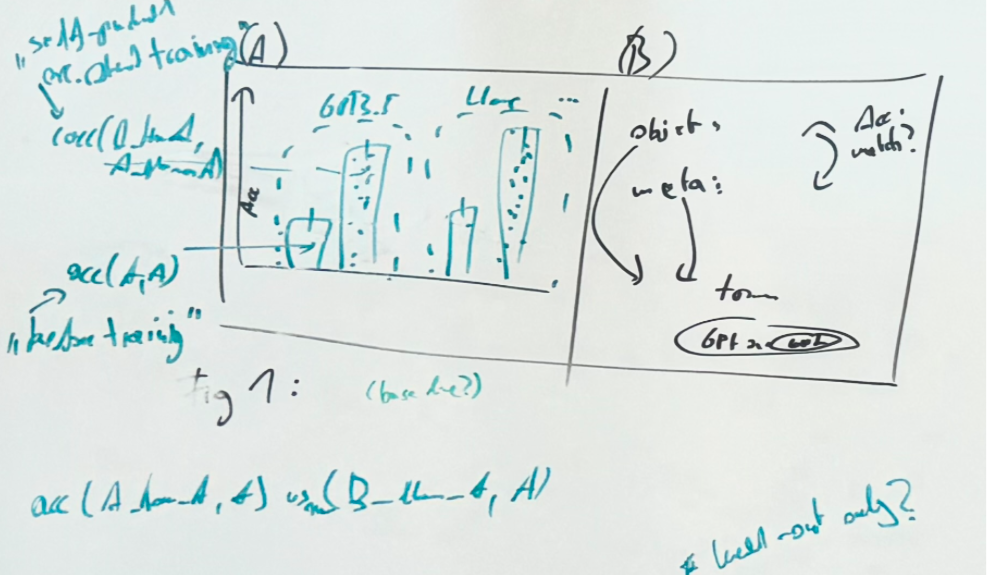

In [ ]:
A_models = {m for m in model_groups.keys() if "fted on" not in m}
A_fton_A_models = {m for m in model_groups.keys() if "fted on" in m}# and m.split(" fted on ")[0] == m.split(" fted on ")[1]}
A_A_fton_A_pairs = []
for A_model in A_models:
    A_data = model_groups[A_model]
    for A_fton_A_model in A_fton_A_models:
        if A_fton_A_model.split(" fted on ")[0] == A_model and A_fton_A_model.split(" fted on ")[1] == A_model:
            A_A_fton_A_pairs.append(({A_model: A_data}, {A_fton_A_model: model_groups[A_fton_A_model]}))

In [ ]:
plot_name = "untrained_vs_trained"
colors = {"A": "indianred", "A_fton_A": "plum", "B_fton_A": "plum"}
fill = {"A_fton_A": True, "B_fton_A": True}
hatching = {"A_fton_A": None, "B_fton_A": None}
alphas = {"A_fton_A": 1, "B_fton_A": 0.5}
bar_width = 0.2
added_labels = set()
positions = np.arange(len(A_A_fton_A_pairs)) * 2 * bar_width * 1.25
num_models_per = 2

fig, ax = plt.subplots(figsize=(4, 4))  # used to be 7,4
plt.subplots_adjust(right=0.8)  # Adjust the right spacing to make room for the legend

# Initialize label sets
added_labels = set()

# keep track of A_models for x ticks
A_models = []


for i, pair in enumerate(A_A_fton_A_pairs):
    pos_base = positions[i]
    A_model, A_group = list(pair[0].items())[0]
    A_fton_A_model, A_fton_A_group = list(pair[1].items())[0]

    A_models.append(A_model)

    # plot the A model
    ax.bar(
        pos_base,
        A_group["A"]["acc"],
        yerr=np.abs(np.array(A_group["A"]["bootstrapped"]).reshape(1, 2).T - A_group["A"]["acc"]),
        capsize=5,
        width=bar_width,
        color=colors["A"],
        label="Before introspection training" if "Before introspection training" not in added_labels else None,
    )

    added_labels.add("Before introspection training")

    # # Add model name label to each bar
    # ax.text(
    #     pos_base,
    #     .033,
    #     A_model,
    #     ha="center",
    #     va="bottom",
    #     color="black",
    #     fontsize=12,
    #     rotation=90,
    #     alpha=0.33
    # )

    # plot baseline
    ax.hlines(
        A_group["A"]["baseline"],
        pos_base - bar_width / 2,
        pos_base + bar_width / 2,
        linestyles="dotted",
        colors="black",
    )

    # plot ceiling
    ceiling = agg_ceiling.loc[A_model, A_model]
    ax.hlines(
        ceiling,
        pos_base - bar_width / 2,
        pos_base + bar_width / 2,
        linestyles="dashed",
        colors="lightgrey",
        label="Highest possible accuracy given non-determinism" if "Highest possible accuracy given non-determinism" not in added_labels else None,
    )

    added_labels.add("Highest possible accuracy given non-determinism")

    # plot the A_fton_A model
    ax.bar(
        pos_base + bar_width,
        A_fton_A_group["A"]["acc"],
        yerr=np.abs(np.array(A_fton_A_group["A"]["bootstrapped"]).reshape(1, 2).T - A_fton_A_group["A"]["acc"]),
        capsize=5,
        width=bar_width,
        color=colors["A_fton_A"],
        label="After introspection training" if "After introspection training" not in added_labels else None,
    )

    added_labels.add("After introspection training")

    # # Add model name label to each bar
    # ax.text(
    #     pos_base+bar_width,
    #     .033,
    #     A_fton_A_model,
    #     ha="center",
    #     va="bottom",
    #     color="black",
    #     fontsize=12,
    #     rotation=90,
    #     alpha=0.33
    # )

    # plot baseline
    ax.hlines(
        A_fton_A_group["A"]["baseline"],
        pos_base - bar_width / 2 + bar_width,
        pos_base + bar_width / 2 + bar_width,
        linestyles="dotted",
        colors="black",
        label="Baseline (predicting modal answer)" if "Baseline (predicting modal answer)" not in added_labels else None,
    )
    added_labels.add("Baseline (predicting modal answer)")

    # plot ceiling
    ceiling = agg_ceiling.loc[A_fton_A_model, A_fton_A_model]
    ax.hlines(
        ceiling,
        pos_base - bar_width / 2 + bar_width,
        pos_base + bar_width / 2 + bar_width,
        linestyles="dashed",
        colors="lightgrey",
        label="Highest possible accuracy given non-determinism" if "Highest possible accuracy given non-determinism" not in added_labels else None,
    )

    added_labels.add("Highest possible accuracy given non-determinism")

    max_r = max(A_group["A"]["acc"], A_fton_A_group["A"]["acc"])

    # # Adjust the size and position of the rounded rectangles
    # rect_height = max_r * 1.05
    # rect_y = 0
    # label_y = rect_y + rect_height + 0.01
    # ax.text(
    #     positions[i] + (num_models_per - 1) * bar_width / 2,
    #     label_y,
    #     f"{A_model}",
    #     ha="center",
    #     va="bottom",
    #     color="black",
    #     fontsize=10,
    #     bbox=dict(facecolor="white", edgecolor="lightgrey", boxstyle="round,pad=0.2"),
    # )
    # rect = patches.Rectangle(
    #     (positions[i] - bar_width / 2, rect_y),
    #     num_models_per * bar_width,
    #     rect_height,
    #     linewidth=1,
    #     edgecolor="lightgrey",
    #     facecolor="none",
    # )
    # rect_patch = patches.FancyBboxPatch(
    #     (positions[i] - bar_width / 2, rect_y),
    #     num_models_per * bar_width,
    #     rect_height,
    #     boxstyle="round,pad=0.033",
    #     linewidth=1,
    #     edgecolor="lightgrey",
    #     facecolor="none",
    # )
    # ax.add_patch(rect_patch)

# ax.set_xlabel("Meta-level model")
ax.set_ylabel("Accuracy")
ax.set_xticks([])
# ax.set_ylim(0, max_r * 1.3)

ax.set_xlim([-0.2, positions[-1] + num_models_per * bar_width])
ax.set_xticks(positions + bar_width / 2)
ax.set_xticklabels(A_models, rotation=45, ha="right")

# Get the current handles and labels from the main plot
handles, labels = ax.get_legend_handles_labels()

# # add light grey baseline explainer
# ax.text(
#     0,
#     -0.15,
#     " ······Baseline of predicting the mode\n(bootstrapped 95% CI)",
#     ha="left",
#     va="center",
#     transform=ax.transAxes,
#     color="grey",
#     fontsize=8,
# )

plt.tight_layout()
if SAVE_PLOTS: plt.savefig(EXP_DIR / STUDY_FOLDERS[0] / "figures" / f"{plot_name}.pdf", bbox_inches='tight')#, bbox_extra_artists=[legend])
plt.show()
legends_fig = plt.figure(figsize=(2, 1))

# we save the legend to it's own file
legend = plt.figlegend(handles, labels, loc='center', frameon=False)
if SAVE_PLOTS: plt.savefig(EXP_DIR / STUDY_FOLDERS[0] / "figures" / f"{plot_name}_legend.pdf", bbox_inches='tight')
# plt.clf()

### Alternate Version of Figure 1
untrained, finetuned on before training, finetuned on after training, other trained models

In [ ]:
A = ("GPT4", "GPT4")
A_fton_A_A = ("GPT4 fted on GPT4", "GPT4")
A_fton_A_A_fton_A = ("GPT4 fted on GPT4", "GPT4 fted on GPT4")
B_fton_A_A = ("GPT3.5 fted on GPT4", "GPT4")

In [ ]:
agg_results.loc[A_fton_A_A_fton_A]

In [ ]:
agg_results.loc[A_fton_A_A]

In [ ]:
agg_results.loc[A]

In [ ]:
agg_results.loc[B_fton_A_A]

In [ ]:
from matplotlib import markers


fig, ax = plt.subplots(figsize=(6, 4))

# plot connecting line
ax.plot([0, 1, 2], [agg_results.loc[A], agg_results.loc[A_fton_A_A], agg_results.loc[A_fton_A_A_fton_A]], color="lightgrey", linestyle="-", marker="")

# plot errors
ax.errorbar([0], agg_results.loc[A], yerr=np.abs(np.array(agg_results_bootstrapped.loc[A]).reshape(1, 2).T - agg_results.loc[A]), fmt="none", ecolor="black", capsize=5)
ax.errorbar([1], agg_results.loc[A_fton_A_A], yerr=np.abs(np.array(agg_results_bootstrapped.loc[A_fton_A_A]).reshape(1, 2).T - agg_results.loc[A_fton_A_A]), fmt="none", ecolor="black", capsize=5)
ax.errorbar([2], agg_results.loc[A_fton_A_A_fton_A], yerr=np.abs(np.array(agg_results_bootstrapped.loc[A_fton_A_A_fton_A]).reshape(1, 2).T - agg_results.loc[A_fton_A_A_fton_A]), fmt="none", ecolor="black", capsize=5)
ax.errorbar([1], agg_results.loc[B_fton_A_A], yerr=np.abs(np.array(agg_results_bootstrapped.loc[B_fton_A_A]).reshape(1, 2).T - agg_results.loc[B_fton_A_A]), fmt="none", ecolor="black", capsize=5)
# Plot the data
ax.plot([0], agg_results.loc[A], "o", color="lavender", label="Before introspection training", markersize=10)
ax.plot([1], agg_results.loc[A_fton_A_A], "o", color="thistle", label="After introspection training", markersize=10)
ax.plot([2], agg_results.loc[A_fton_A_A_fton_A], "o", color="plum", label="After introspection training on same model", markersize=10)
ax.plot([1], agg_results.loc[B_fton_A_A], "o", color="khaki", label="After introspection training on GPT4", markersize=10)

# add labels
ax.set_xticks([0,1,2])
ax.set_xticklabels(["No training", "Pre-training behavior", "Post-training behavior"])
ax.set_ylabel("Accuracy")

plt.show()
if SAVE_PLOTS: plt.savefig(EXP_DIR / STUDY_FOLDERS[0] / "figures" / "intro_fig_alt.pdf", bbox_inches='tight')

### Figure 2: Models can predict themselves better than they can predict others
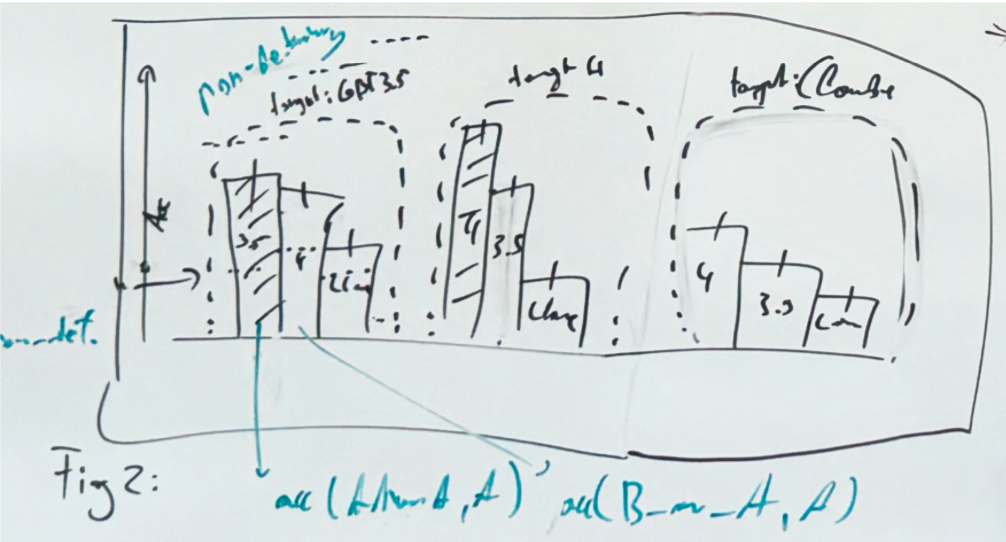

In [ ]:
# we need to make groups according to target model
target_models = set([k.split(" fted on ")[1] for k in model_groups.keys() if "fted on" in k])
ft_model_groups = {k:v for k, v in model_groups.items() if " fted on " in k}

plot_2_model_groups = {}
for target_model in target_models:
    plot_2_model_groups[target_model] = {k: v for k, v in ft_model_groups.items() if k.split(" fted on ")[1] == target_model}


In [ ]:
# we to sort each subgroup so that the A_fton_A model is always first
for target_model, group in plot_2_model_groups.items():
    # get the A_fton_A model
    try:
        a_fton_a_model = plot_2_model_groups[target_model][f"{target_model} fted on {target_model}"]
    except KeyError:
        print(f"Could not find A_fton_A model for {target_model}")
        continue
    # sort the group
    plot_2_model_groups[target_model] = {k: v for k, v in sorted(group.items(), key=lambda x: x[0] != f"{target_model} fted on {target_model}")}

In [ ]:
colors = {"A_fton_A": "plum", "B_fton_A": "plum"}
fill = {"A_fton_A": True, "B_fton_A": True}
hatching = {"A_fton_A": None, "B_fton_A": None}
alphas = {"A_fton_A": 1, "B_fton_A": 0.5}
bar_width = 0.2
added_labels = set()
num_models_per = max([len(list(g)) for g in plot_2_model_groups.values()])
positions = np.arange(len(plot_2_model_groups)) * (num_models_per + 1) * bar_width

fig, ax = plt.subplots(figsize=(10, 4))  # used to be 6,4
max_r = max([r["B"]["acc"] for group in plot_2_model_groups.values() for r in group.values()])

for i, (target_model, group) in enumerate(plot_2_model_groups.items()):
    for j, (ft_model, r) in enumerate(group.items()):
        pos_base = positions[i] + j * bar_width
        r = r["B"]
        if ft_model == f"{target_model} fted on {target_model}":
            bar = ax.bar(
                pos_base,
                r["acc"],
                yerr=np.abs(np.array(r["bootstrapped"]).reshape(1, 2).T - r["acc"]),
                capsize=5,
                width=bar_width,
                color=colors["A_fton_A"],
                label="Predicting itself" if "Predicting itself" not in added_labels else "",
                fill=fill["A_fton_A"],
                hatch=hatching["A_fton_A"],
                alpha=alphas["A_fton_A"],
            )
            added_labels.add("Predicting itself")
        else:
            bar = ax.bar(
                pos_base,
                r["acc"],
                yerr=np.abs(np.array(r["bootstrapped"]).reshape(1, 2).T - r["acc"]),
                capsize=5,
                width=bar_width,
                color=colors["B_fton_A"],
                label="Predicting other model" if "Predicting other model" not in added_labels else "",
                fill=fill["B_fton_A"],
                hatch=hatching["B_fton_A"],
                alpha=alphas["B_fton_A"],
            )
            added_labels.add("Predicting other model")

        # Add model name label to each bar
        ax.text(
            pos_base,
            0.05,
            ft_model.split(" fted on ")[0],
            ha="center",
            va="bottom",
            color="black",
            fontsize=12,
            rotation=90,
            alpha=0.33,
        )

        ax.hlines(
            r["baseline"],
            pos_base - bar_width / 2,
            pos_base + bar_width / 2,
            linestyles="dotted",
            colors="black",
            label=(
                "Baseline (predicting modal answer)" if "Baseline (predicting modal answer)" not in added_labels else None
            ),
        )
        added_labels.add("Baseline (predicting modal answer)")

        # add ceiling
        ceiling = agg_ceiling.loc[ft_model, ft_model]
        ax.hlines(
            ceiling,
            pos_base - bar_width / 2,
            pos_base + bar_width / 2,
            linestyles="dashed",
            colors="lightgrey",
            label="Highest possible accuracy given non-determinism" if "Highest possible accuracy given non-determinism" not in added_labels else None,
        )
        added_labels.add("Highest possible accuracy given non-determinism")

    # Adjust the size and position of the rounded rectangles
    rect_height = max_r * 1.05
    rect_y = 0
    label_y = rect_y + rect_height + 0.01
    ax.text(
        positions[i] + (num_models_per - 1) * bar_width / 2,
        label_y,
        f"Trained on\n{target_model}",
        ha="center",
        va="bottom",
        color="black",
        fontsize=10,
        bbox=dict(facecolor="white", edgecolor="lightgrey", boxstyle="round,pad=0.2"),
    )
    rect = patches.Rectangle(
        (positions[i] - bar_width / 2, rect_y),
        num_models_per * bar_width,
        rect_height,
        linewidth=1,
        edgecolor="lightgrey",
        facecolor="none",
    )
    rect_patch = patches.FancyBboxPatch(
        (positions[i] - bar_width / 2, rect_y),
        num_models_per * bar_width,
        rect_height,
        boxstyle="round,pad=0.033",
        linewidth=1,
        edgecolor="lightgrey",
        facecolor="none",
    )
    ax.add_patch(rect_patch)

# ax.set_xlabel("Meta-level model")
ax.set_ylabel("Accuracy")
ax.set_xticks([])
# ax.set_ylim(0, max_r * 1.3)

# Get the current handles and labels from the main plot
handles, labels = ax.get_legend_handles_labels()

# add light grey baseline explainer
# ax.text(
#     0,
#     -0.15,
#     " ······Baseline of predicting the mode\n(bootstrapped 95% CI)",
#     ha="left",
#     va="center",
#     transform=ax.transAxes,
#     color="grey",
#     fontsize=8,
# )

plt.tight_layout()
if SAVE_PLOTS: plt.savefig(EXP_DIR / STUDY_FOLDERS[0] / "figures" / "predicting_self_vs_other.pdf", bbox_inches="tight")
plt.show()

# we save the legend to it's own file
leg_fig = plt.figure(figsize=(2, 1))
legend = plt.figlegend(handles, labels, loc="center", frameon=False)
if SAVE_PLOTS: plt.savefig(EXP_DIR / STUDY_FOLDERS[0] / "figures" / "predicting_self_vs_other_legend.pdf", bbox_inches="tight")

### Figure 3: Models predict their actual behavior, not their training data
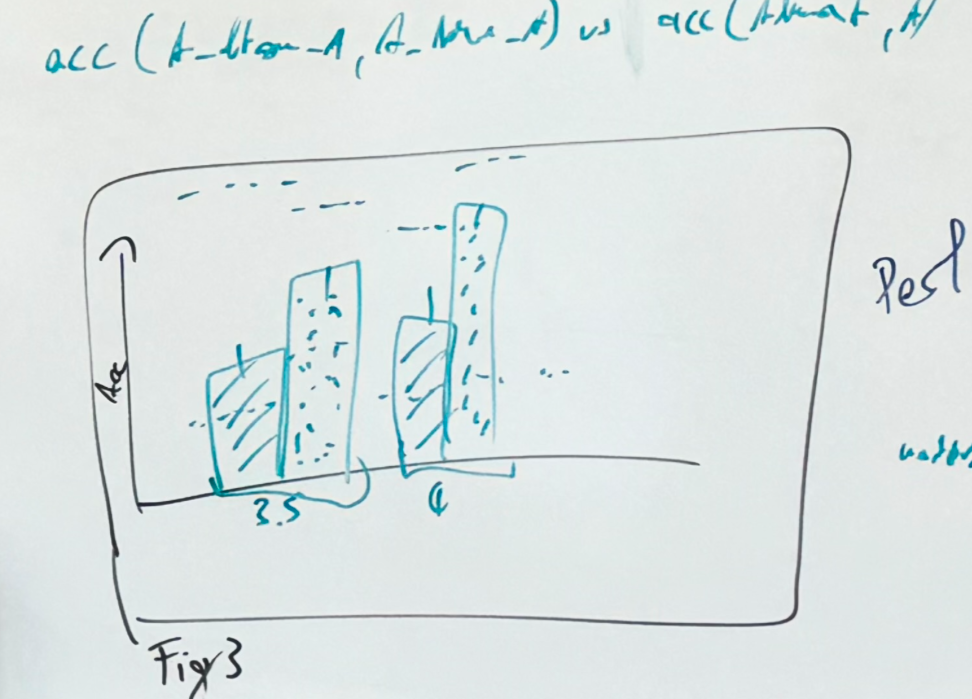

In [ ]:
# filter model groups to only incldue A, A_fton_A ones
plot_1_model_groups = {}

for model, group in model_groups.items():
    if "fted on" not in model:
        plot_1_model_groups[model] = group
    else:
        model_A = model.split(" fted on ")[0]
        model_B = model.split(" fted on ")[1]
        if model_A == model_B:
            plot_1_model_groups[model] = group

# plot_1_model_groups

In [ ]:
plot_1_model_groups

In [ ]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Define some colors for each category
colors = {"A": "indianred", "B": "plum", "A_fton_B": "darkmagenta"}

# Width of each bar
bar_width = 0.2

# Separate entries into two categories
# a_only_entries = {k: v for k, v in plot_1_model_groups.items() if "fted on" not in k}
other_entries = {k: v for k, v in plot_1_model_groups.items() if "fted on" in k}

# Initialize label sets
added_labels = set()

# # Plot A-only entries first
# a_only_positions = np.arange(len(a_only_entries)) * (bar_width + 0.1)  # Narrower bars with some space
# for i, (model, r) in enumerate(a_only_entries.items()):
#     pos_base = a_only_positions[i]
#     if "Untrained Model" not in added_labels:
#         ax.bar(
#             pos_base,
#             r["A"]["acc"],
#             yerr=np.abs(np.array(r["A"]["bootstrapped"]).reshape(1, 2).T - r["A"]["acc"]),
#             capsize=5,
#             width=bar_width,
#             color=colors["A"],
#         )
#         added_labels.add("Untrained Model")
#     else:
#         ax.bar(
#             pos_base,
#             r["A"]["acc"],
#             yerr=np.abs(np.array(r["A"]["bootstrapped"]).reshape(1, 2).T - r["A"]["acc"]),
#             capsize=5,
#             width=bar_width,
#             color=colors["A"],
#         )
#     ax.hlines(
#         r["A"]["baseline"], pos_base - bar_width / 2, pos_base + bar_width / 2, linestyles="dotted", colors="black"
#     )

# Plot other entries
other_positions = bar_width + 0.1 + np.arange(len(other_entries)) * (2 * bar_width + 0.1)
for i, (model, r) in enumerate(other_entries.items()):
    pos_base = other_positions[i]
    if "Training Target" not in added_labels:
        ax.bar(
            pos_base,
            r["A"]["acc"],
            yerr=np.abs(np.array(r["A"]["bootstrapped"]).reshape(1, 2).T - r["A"]["acc"]),
            capsize=5,
            width=bar_width,
            color=colors["B"],
            label="Behavior before training" if "Behavior before training" not in added_labels else None,
        )
        added_labels.add("Behavior before training")
    else:
        ax.bar(
            pos_base,
            r["A"]["acc"],
            yerr=np.abs(np.array(r["A"]["bootstrapped"]).reshape(1, 2).T - r["A"]["acc"]),
            capsize=5,
            width=bar_width,
            color=colors["B"],
        )
    ax.hlines(
        r["A"]["baseline"], pos_base - bar_width / 2, pos_base + bar_width / 2, linestyles="dotted", colors="black"
    )

    if "Finetuned Model" not in added_labels:
        ax.bar(
            pos_base + bar_width,
            r["A_fton_B"]["acc"],
            yerr=np.abs(np.array(r["A_fton_B"]["bootstrapped"]).reshape(1, 2).T - r["A_fton_B"]["acc"]),
            capsize=5,
            width=bar_width,
            color=colors["A_fton_B"],
            label="Behavior after training" if "Behavior after training" not in added_labels else None,
        )
        added_labels.add("Behavior after training")
    else:
        ax.bar(
            pos_base + bar_width,
            r["A_fton_B"]["acc"],
            yerr=np.abs(np.array(r["A_fton_B"]["bootstrapped"]).reshape(1, 2).T - r["A_fton_B"]["acc"]),
            capsize=5,
            width=bar_width,
            color=colors["A_fton_B"],
        )
    ax.hlines(
        r["A_fton_B"]["baseline"],
        pos_base + bar_width / 2,
        pos_base + 3 * bar_width / 2,
        linestyles="dotted",
        colors="black",
        label = "Baseline (predicting modal answer)" if "Baseline (predicting modal answer)" not in added_labels else None,
    )
    added_labels.add("Baseline (predicting modal answer")

    # add ceiling
    ceiling = agg_ceiling.loc[model, model]
    ax.hlines(
        ceiling,
        pos_base - bar_width / 2,
        pos_base + 3 * bar_width / 2,
        linestyles="dashed",
        colors="lightgrey",
        label="Highest possible accuracy given non-determinism" if "Highest possible accuracy given non-determinism" not in added_labels else None,
    )
    added_labels.add("Highest possible accuracy given non-determinism")

# Set title and labels
# ax.set_xlabel("Meta-level model")
ax.set_ylabel("Accuracy")

# Set x-ticks and labels
tick_positions = (
    (other_positions + bar_width / 2)
)  # Center the ticks between the groups
ax.set_xticks(tick_positions)
source_models = [k.split(" fted on ")[0] for k in other_entries.keys()]
ax.set_xticklabels(source_models, rotation=45, ha="right")

# Set y-axis limits
ax.set_ylim(0)

# Get the current handles and labels from the main plot
handles, labels = ax.get_legend_handles_labels()

# add light grey baseline explainer
# ax.text(
#     -.05,
#     -0.4,
#     " ······Baseline of predicting the mode\n(bootstrapped 95% CI)",
#     ha="left",
#     va="center",
#     transform=ax.transAxes,
#     color="grey",
#     fontsize=8,
# )

# Show plot
plt.tight_layout()
if SAVE_PLOTS: plt.savefig(EXP_DIR / STUDY_FOLDERS[0] / "figures" / "target_vs_actual_behavior.pdf", bbox_inches='tight')
plt.show()

# we save the legend to it's own file
leg_fig = plt.figure(figsize=(2, 1))
legend = plt.figlegend(handles, labels, loc='center', frameon=False, title = "Prediction matches...")
if SAVE_PLOTS: plt.savefig(EXP_DIR / STUDY_FOLDERS[0] / "figures" / "target_vs_actual_behavior_legend.pdf", bbox_inches='tight')

### Figure 4: Special comparisions

In [ ]:
# which bars on the object/meta level do we want to plot?
# (object level label, meta level label)
bars = [
    ("GPT4 fted on Finetuned GPT3.5", "Finetuned GPT3.5"),
    ("GPT4 fted on GPT3.5 (1106)", "GPT3.5"),
    ("Finetuned GPT3.5", "Finetuned GPT3.5"),
    ("GPT3.5 fted on Finetuned GPT3.5", "Finetuned GPT3.5"),
]
colors = ["lightpink", "thistle", "plum", "darkmagenta"]
names = [f"{b[0]}\npredicting\n{b[1]}" for b in bars]
label_texts = [
    "Post-training behavior predict by other model",
    "Pre-training behavoir predicts by other model",
    "Post-training behavior predict by itself",
    "Post-training behavior predict by itself twice",
]

In [ ]:
{b:agg_results.loc[b] for b in bars}

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

values = []
CIs = []
baselines = []
ceilings = []
for bar in bars:
    object_model = bar[1]
    meta_model = bar[0]
    value = agg_results.loc[meta_model, object_model]
    values.append(value)
    CI = agg_results_bootstrapped.loc[meta_model, object_model]
    CIs.append(CI)
    baseline = mode_baseline_agg_results.loc[meta_model, object_model]
    baselines.append(baseline)
    ceiling = agg_ceiling.loc[meta_model, object_model]
    ceilings.append(ceiling)

plt.bar(
    names,
    values,
    yerr=np.abs(np.array(values) - np.array(CIs).T),
    capsize=5,
    color=colors,
)

for i, bar in enumerate(bars):    
    # plot baseline
    ax.hlines(
        baselines[i],
        i - 0.5,
        i + 0.5,
        linestyles="dotted",
        colors="black",
    )
    # plot ceiling
    ax.hlines(
        ceilings[i],
        i - 0.5,
        i + 0.5,
        linestyles="dashed",
        colors="lightgrey",
    )

# Set title and labels
ax.set_xticklabels(names, rotation=45, ha="right")
ax.set_ylabel("Accuracy")

if SAVE_PLOTS: plt.savefig(EXP_DIR / STUDY_FOLDERS[0] / "figures" / "specific_models.pdf", bbox_inches='tight')
plt.show()

# we save the legend to it's own file
leg_fig = plt.figure(figsize=(2, 1))
labels = label_texts
legend = plt.figlegend(handles, labels, loc='center', frameon=False, title = "Prediction matches...")
if SAVE_PLOTS: plt.savefig(EXP_DIR / STUDY_FOLDERS[0] / "figures" / "specific_models_legend.pdf", bbox_inches='tight')

#### Special figure for playing around

In [ ]:
# which bars on the object/meta level do we want to plot?
# (object level label, meta level label)
bars = [
    ("GPT3.5 (1106) fted on GPT3.5 (1106)", "GPT3.5 (1106) fted on GPT3.5 (1106)"),
    ("GPT3.5 (1106) fted on GPT3.5 (1106)","GPT3.5 (1106)"),
    ("GPT4 fted on Finetuned GPT3.5", "Finetuned GPT3.5"),
    ("GPT4 fted on GPT3.5 (1106)", "GPT3.5 (1106)"),
    ("Finetuned GPT3.5", "Finetuned GPT3.5"),
    ("GPT3.5 fted on Finetuned GPT3.5", "Finetuned GPT3.5"),
    ("GPT3.5 fted on Finetuned GPT3.5", "GPT3.5 fted on Finetuned GPT3.5"),
]
colors = ["grey"] * len(bars)
names = [f"{b[0]}\npredicting\n{b[1]}" for b in bars]
label_texts = names

In [ ]:
{b:agg_results.loc[b] for b in bars}

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

normalize_by_ceiling = True
values = []
CIs = []
baselines = []
ceilings = []
for bar in bars:
    object_model = bar[1]
    meta_model = bar[0]
    value = agg_results.loc[meta_model, object_model] 
    # normalize
    if normalize_by_ceiling: value = value / agg_ceiling.loc[meta_model, object_model]
    values.append(value)
    CI = agg_results_bootstrapped.loc[meta_model, object_model]
    if normalize_by_ceiling: CI = CI / agg_ceiling.loc[meta_model, object_model]
    CIs.append(CI)
    baseline = mode_baseline_agg_results.loc[meta_model, object_model]
    if normalize_by_ceiling: baseline = baseline / agg_ceiling.loc[meta_model, object_model]
    baselines.append(baseline)
    ceiling = agg_ceiling.loc[meta_model, object_model]
    if normalize_by_ceiling: ceiling = 1
    ceilings.append(ceiling)

plt.bar(
    names,
    values,
    yerr=np.abs(np.array(values) - np.array(CIs).T),
    capsize=5,
    color=colors,
)

for i, bar in enumerate(bars):    
    # plot baseline
    ax.hlines(
        baselines[i],
        i - 0.5,
        i + 0.5,
        linestyles="dotted",
        colors="black",
    )
    # plot ceiling
    ax.hlines(
        ceilings[i],
        i - 0.5,
        i + 0.5,
        linestyles="dashed",
        colors="lightgrey",
    )

# Set title and labels
ax.set_xticklabels(names, rotation=45, ha="right")
ax.set_ylabel("Accuracy")

plt.ylim(0.33, 0.66)

if SAVE_PLOTS: plt.savefig(EXP_DIR / STUDY_FOLDERS[0] / "figures" / "specific_models.pdf", bbox_inches='tight')
plt.show()

# we save the legend to it's own file
leg_fig = plt.figure(figsize=(2, 1))
labels = label_texts
legend = plt.figlegend(handles, labels, loc='center', frameon=False, title = "Prediction matches...")
if SAVE_PLOTS: plt.savefig(EXP_DIR / STUDY_FOLDERS[0] / "figures" / "specific_models_legend.pdf", bbox_inches='tight')

### Old figures
#### `acc(A_fton_A, A_fton_A) vs acc(A_fton_A, A)`

In [ ]:
# filter model groups to only incldue A, A_fton_A ones
plot_1_model_groups = {}

for model, group in model_groups.items():
    if "fted" not in model:
        plot_1_model_groups[model] = group
    else:
        model_A = model.split(" fted on ")[0]
        model_B = model.split(" fted on ")[1]
        if model_A == model_B:
            plot_1_model_groups[model] = group

# plot_1_model_groups

In [ ]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Define some colors for each category
colors = {'A': 'indianred', 'B': 'plum', 'A_fton_B': 'indianred'}

# Width of each bar
bar_width = 0.2

# Separate entries into two categories
a_only_entries = {k: v for k, v in plot_1_model_groups.items() if "fted on" not in k}
other_entries = {k: v for k, v in plot_1_model_groups.items() if "fted on" in k}

# Initialize label sets
added_labels = set()

# Plot A-only entries first
a_only_positions = np.arange(len(a_only_entries)) * (bar_width + 0.1)  # Narrower bars with some space
for i, (model, r) in enumerate(a_only_entries.items()):
    pos_base = a_only_positions[i]
    if "Untrained Model" not in added_labels:
        ax.bar(pos_base, r["A"]["acc"], yerr=np.abs(np.array(r["A"]['bootstrapped']).reshape(1, 2).T - r["A"]["acc"]), capsize=5, width=bar_width, color=colors['A'])
        added_labels.add("Untrained Model")
    else:
        ax.bar(pos_base, r["A"]["acc"], yerr=np.abs(np.array(r["A"]['bootstrapped']).reshape(1, 2).T - r["A"]["acc"]), capsize=5, width=bar_width, color=colors['A'])
    ax.hlines(r["A"]["baseline"], pos_base - bar_width / 2, pos_base + bar_width / 2, linestyles='dotted', colors='black')

# Plot other entries
other_positions = max(a_only_positions) + bar_width + 0.1 + np.arange(len(other_entries)) * (2 * bar_width + 0.1)
for i, (model, r) in enumerate(other_entries.items()):
    pos_base = other_positions[i]
    if "Training Target" not in added_labels:
        ax.bar(pos_base, r["A"]["acc"], yerr=np.abs(np.array(r["A"]['bootstrapped']).reshape(1, 2).T - r["A"]["acc"]), capsize=5, width=bar_width, color=colors['B'], label="Training Target")
        added_labels.add("Training Target")
    else:
        ax.bar(pos_base, r["A"]["acc"], yerr=np.abs(np.array(r["A"]['bootstrapped']).reshape(1, 2).T - r["A"]["acc"]), capsize=5, width=bar_width, color=colors['B'])
    ax.hlines(r["A"]["baseline"], pos_base - bar_width / 2, pos_base + bar_width / 2, linestyles='dotted', colors='black')

    if "Finetuned Model" not in added_labels:
        ax.bar(pos_base + bar_width, r["A_fton_B"]["acc"], yerr=np.abs(np.array(r["A_fton_B"]['bootstrapped']).reshape(1, 2).T - r["A_fton_B"]["acc"]), capsize=5, width=bar_width, color=colors['A_fton_B'], label="Itself")
        added_labels.add("Finetuned Model")
    else:
        ax.bar(pos_base + bar_width, r["A_fton_B"]["acc"], yerr=np.abs(np.array(r["A_fton_B"]['bootstrapped']).reshape(1, 2).T - r["A_fton_B"]["acc"]), capsize=5, width=bar_width, color=colors['A_fton_B'])
    ax.hlines(r["A_fton_B"]["baseline"], pos_base + bar_width / 2, pos_base + 3 * bar_width / 2, linestyles='dotted', colors='black')

# Set title and labels
ax.set_xlabel("Meta-level model")
ax.set_ylabel("Accuracy")

# Set x-ticks and labels
tick_positions = np.concatenate((a_only_positions, other_positions + bar_width / 2))  # Center the ticks between the groups
ax.set_xticks(tick_positions)
ax.set_xticklabels(list(a_only_entries.keys()) + list(other_entries.keys()), rotation=45, ha="right")

# Set y-axis limits
ax.set_ylim(0)

# Add legend
ax.legend(title="Meta-level model predicts")

# add light grey baseline explainer
ax.text(
    -.05,
    -0.4,
    " ······Baseline of predicting the mode\n(bootstrapped 95% CI)",
    ha="left",
    va="center",
    transform=ax.transAxes,
    color="grey",
    fontsize=8,
)

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
# version without the bars
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Define some colors for each category
colors = {'A': 'indianred', 'B': 'plum', 'A_fton_B': 'indianred'}

# Width of each bar
bar_width = 0.2

# Separate entries into two categories
a_only_entries = {k: v for k, v in plot_1_model_groups.items() if "fted on" not in k}
other_entries = {k: v for k, v in plot_1_model_groups.items() if "fted on" in k}

# Initialize label sets
added_labels = set()

# Plot A-only entries first
a_only_positions = np.arange(len(a_only_entries)) * (bar_width + 0.1)  # Narrower bars with some space
for i, (model, r) in enumerate(a_only_entries.items()):
    pos_base = a_only_positions[i]
    if "Untrained Model" not in added_labels:
        ax.bar(pos_base, r["A"]["acc"], yerr=np.abs(np.array(r["A"]['bootstrapped']).reshape(1, 2).T - r["A"]["acc"]), capsize=5, width=bar_width, color=colors['A'], alpha=0, error_kw=dict(alpha=0))
        added_labels.add("Untrained Model")
    else:
        ax.bar(pos_base, r["A"]["acc"], yerr=np.abs(np.array(r["A"]['bootstrapped']).reshape(1, 2).T - r["A"]["acc"]), capsize=5, width=bar_width, color=colors['A'], alpha=0, error_kw=dict(alpha=0))
    ax.hlines(r["A"]["baseline"], pos_base - bar_width / 2, pos_base + bar_width / 2, linestyles='dotted', colors='black')

# Plot other entries
other_positions = max(a_only_positions) + bar_width + 0.1 + np.arange(len(other_entries)) * (2 * bar_width + 0.1)
for i, (model, r) in enumerate(other_entries.items()):
    pos_base = other_positions[i]
    if "Training Target" not in added_labels:
        ax.bar(pos_base, r["B"]["acc"], yerr=np.abs(np.array(r["B"]['bootstrapped']).reshape(1, 2).T - r["B"]["acc"]), capsize=5, width=bar_width, color=colors['B'], label="Training Target", alpha=0, error_kw=dict(alpha=0))
        added_labels.add("Training Target")
    else:
        ax.bar(pos_base, r["B"]["acc"], yerr=np.abs(np.array(r["B"]['bootstrapped']).reshape(1, 2).T - r["B"]["acc"]), capsize=5, width=bar_width, color=colors['B'], alpha=0, error_kw=dict(alpha=0))
    ax.hlines(r["B"]["baseline"], pos_base - bar_width / 2, pos_base + bar_width / 2, linestyles='dotted', colors='black')

    if "Finetuned Model" not in added_labels:
        ax.bar(pos_base + bar_width, r["A_fton_B"]["acc"], yerr=np.abs(np.array(r["A_fton_B"]['bootstrapped']).reshape(1, 2).T - r["A_fton_B"]["acc"]), capsize=5, width=bar_width, color=colors['A_fton_B'], label="Itself", alpha=0, error_kw=dict(alpha=0))
        added_labels.add("Finetuned Model")
    else:
        ax.bar(pos_base + bar_width, r["A_fton_B"]["acc"], yerr=np.abs(np.array(r["A_fton_B"]['bootstrapped']).reshape(1, 2).T - r["A_fton_B"]["acc"]), capsize=5, width=bar_width, color=colors['A_fton_B'], alpha=0, error_kw=dict(alpha=0))
    ax.hlines(r["A_fton_B"]["baseline"], pos_base + bar_width / 2, pos_base + 3 * bar_width / 2, linestyles='dotted', colors='black')

# Set title and labels
ax.set_xlabel("Meta-level model")
ax.set_ylabel("Accuracy")

# Set x-ticks and labels
tick_positions = np.concatenate((a_only_positions, other_positions + bar_width / 2))  # Center the ticks between the groups
ax.set_xticks(tick_positions)
ax.set_xticklabels(list(a_only_entries.keys()) + list(other_entries.keys()), rotation=45, ha="right")

# Set y-axis limits
ax.set_ylim(0)

# Add legend
ax.legend(title="Meta-level model predicts")

# add light grey baseline explainer
ax.text(
    -.05,
    -0.4,
    " ······Baseline of predicting the mode\n(bootstrapped 95% CI)",
    ha="left",
    va="center",
    transform=ax.transAxes,
    color="grey",
    fontsize=8,
)

# Show plot
plt.tight_layout()
plt.show()


#### `acc(A_fton_A, A) vs acc(B_fton_A, A)`

In [ ]:
# we need to make groups according to target model
target_models = set([k.split(" fted on ")[1] for k in model_groups.keys() if "fted on" in k])
ft_model_groups = {k:v for k, v in model_groups.items() if " fted on " in k}

plot_2_model_groups = {}
for target_model in target_models:
    plot_2_model_groups[target_model] = {k: v for k, v in ft_model_groups.items() if k.split(" fted on ")[1] == target_model}


In [ ]:
# we to sort each subgroup so that the A_fton_A model is always first
for target_model, group in plot_2_model_groups.items():
    # get the A_fton_A model
    try:
        a_fton_a_model = plot_2_model_groups[target_model][f"{target_model} fted on {target_model}"]
    except KeyError:
        print(f"Could not find A_fton_A model for {target_model}")
        continue
    # sort the group
    plot_2_model_groups[target_model] = {k: v for k, v in sorted(group.items(), key=lambda x: x[0] != f"{target_model} fted on {target_model}")}

In [ ]:
colors = {"A_fton_A": "plum", "B_fton_A": "plum"}
fill = {"A_fton_A": True, "B_fton_A": True}
hatching = {"A_fton_A": None, "B_fton_A": None}
alphas = {"A_fton_A": 1, "B_fton_A": 0.5}
bar_width = 0.2
added_labels = set()
num_models_per = max([len(list(g)) for g in plot_2_model_groups.values()])
positions = np.arange(len(plot_2_model_groups)) * (num_models_per + 1) * bar_width

fig, ax = plt.subplots(figsize=(10, 4)) # used to be 7,4 
max_r = max([r["B"]["acc"] for group in plot_2_model_groups.values() for r in group.values()])

for i, (target_model, group) in enumerate(plot_2_model_groups.items()):
    for j, (ft_model, r) in enumerate(group.items()):
        pos_base = positions[i] + j * bar_width
        r = r["B"]
        if ft_model == f"{target_model} fted on {target_model}":
            bar = ax.bar(
                pos_base,
                r["acc"],
                yerr=np.abs(np.array(r["bootstrapped"]).reshape(1, 2).T - r["acc"]),
                capsize=5,
                width=bar_width,
                color=colors["A_fton_A"],
                label="Predicting itself" if "Predicting itself" not in added_labels else "",
                fill=fill["A_fton_A"],
                hatch=hatching["A_fton_A"],
                alpha=alphas["A_fton_A"],
            )
            added_labels.add("Predicting itself")
        else:
            bar = ax.bar(
                pos_base,
                r["acc"],
                yerr=np.abs(np.array(r["bootstrapped"]).reshape(1, 2).T - r["acc"]),
                capsize=5,
                width=bar_width,
                color=colors["B_fton_A"],
                label="Predicting other model" if "Predicting other model" not in added_labels else "",
                fill=fill["B_fton_A"],
                hatch=hatching["B_fton_A"],
                alpha=alphas["B_fton_A"],
            )
            added_labels.add("Predicting other model")
        
        # Add model name label to each bar
        ax.text(
            pos_base,
            .05,
            ft_model.split(" fted on ")[0],
            ha="center",
            va="bottom",
            color="black",
            fontsize=12,
            rotation=90,
            alpha=0.33
        )
        
        ax.hlines(
            r["baseline"], pos_base - bar_width / 2, pos_base + bar_width / 2, linestyles="dotted", colors="black"
        )

    # Adjust the size and position of the rounded rectangles
    rect_height = max_r * 1.05
    rect_y = 0
    label_y = rect_y + rect_height + 0.01
    ax.text(
        positions[i] + (num_models_per - 1) * bar_width / 2,
        label_y,
        f"Trained on\n{target_model}",
        ha="center",
        va="bottom",
        color="black",
        fontsize=10,
        bbox=dict(facecolor="white", edgecolor="lightgrey", boxstyle="round,pad=0.2"),
    )
    rect = patches.Rectangle(
        (positions[i] - bar_width / 2, rect_y),
        num_models_per * bar_width,
        rect_height,
        linewidth=1,
        edgecolor="lightgrey",
        facecolor="none",
    )
    rect_patch = patches.FancyBboxPatch(
        (positions[i] - bar_width / 2, rect_y),
        num_models_per * bar_width,
        rect_height,
        boxstyle="round,pad=0.033",
        linewidth=1,
        edgecolor="lightgrey",
        facecolor="none",
    )
    ax.add_patch(rect_patch)

ax.set_xlabel("Meta-level model")
ax.set_ylabel("Accuracy")
ax.set_xticks([])
ax.set_ylim(0, max_r * 1.3)

# legend off to the side
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlim([-0.2, positions[-1] + num_models_per * bar_width])

# add light grey baseline explainer
ax.text(
    0,
    -0.15,
    " ······Baseline of predicting the mode\n(bootstrapped 95% CI)",
    ha="left",
    va="center",
    transform=ax.transAxes,
    color="grey",
    fontsize=8,
)

plt.tight_layout()
plt.show()

#### first attempts

In [ ]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Define some colors for each category
colors = {'A': 'gold', 'B': 'plum', 'A_fton_B': 'indianred'}

# Width of each bar
bar_width = 0.2

# Separate entries into two categories
a_only_entries = {k: v for k, v in model_groups.items() if "fted on" not in k}
other_entries = {k: v for k, v in model_groups.items() if "fted on" in k}

# Initialize label sets
added_labels = set()

# Plot A-only entries first
a_only_positions = np.arange(len(a_only_entries)) * (bar_width + 0.1)  # Narrower bars with some space
for i, (model, r) in enumerate(a_only_entries.items()):
    pos_base = a_only_positions[i]
    if "Untrained Model" not in added_labels:
        ax.bar(pos_base, r["A"]["acc"], yerr=np.abs(np.array(r["A"]['bootstrapped']).reshape(1, 2).T - r["A"]["acc"]), capsize=5, width=bar_width, label="Untrained Model", color=colors['A'])
        added_labels.add("Untrained Model")
    else:
        ax.bar(pos_base, r["A"]["acc"], yerr=np.abs(np.array(r["A"]['bootstrapped']).reshape(1, 2).T - r["A"]["acc"]), capsize=5, width=bar_width, color=colors['A'])
    ax.hlines(r["A"]["baseline"], pos_base - bar_width / 2, pos_base + bar_width / 2, linestyles='dotted', colors='black')

# Plot other entries
other_positions = max(a_only_positions) + 0.75 + np.arange(len(other_entries)) * (2 * bar_width + 0.1)
for i, (model, r) in enumerate(other_entries.items()):
    pos_base = other_positions[i]
    if "Training Target" not in added_labels:
        ax.bar(pos_base, r["B"]["acc"], yerr=np.abs(np.array(r["B"]['bootstrapped']).reshape(1, 2).T - r["B"]["acc"]), capsize=5, width=bar_width, color=colors['B'], label="Training Target")
        added_labels.add("Training Target")
    else:
        ax.bar(pos_base, r["B"]["acc"], yerr=np.abs(np.array(r["B"]['bootstrapped']).reshape(1, 2).T - r["B"]["acc"]), capsize=5, width=bar_width, color=colors['B'])
    ax.hlines(r["B"]["baseline"], pos_base - bar_width / 2, pos_base + bar_width / 2, linestyles='dotted', colors='black')

    if "Finetuned Model" not in added_labels:
        ax.bar(pos_base + bar_width, r["A_fton_B"]["acc"], yerr=np.abs(np.array(r["A_fton_B"]['bootstrapped']).reshape(1, 2).T - r["A_fton_B"]["acc"]), capsize=5, width=bar_width, color=colors['A_fton_B'], label="Finetuned Model")
        added_labels.add("Finetuned Model")
    else:
        ax.bar(pos_base + bar_width, r["A_fton_B"]["acc"], yerr=np.abs(np.array(r["A_fton_B"]['bootstrapped']).reshape(1, 2).T - r["A_fton_B"]["acc"]), capsize=5, width=bar_width, color=colors['A_fton_B'])
    ax.hlines(r["A_fton_B"]["baseline"], pos_base + bar_width / 2, pos_base + 3 * bar_width / 2, linestyles='dotted', colors='black')

# Set title and labels
ax.set_xlabel("Meta-level model")
ax.set_ylabel("Accuracy")

# Set x-ticks and labels
tick_positions = np.concatenate((a_only_positions, other_positions + bar_width / 2))  # Center the ticks between the groups
ax.set_xticks(tick_positions)
ax.set_xticklabels(list(a_only_entries.keys()) + list(other_entries.keys()), rotation=45, ha="right")

# Set y-axis limits
ax.set_ylim(0)

# Add legend
ax.legend(title="Comparing against")

# add light grey baseline explainer
ax.text(
    0,
    -0.4,
    " ······Baseline of predicting the mode\n(bootstrapped 95% CI)",
    ha="left",
    va="center",
    transform=ax.transAxes,
    color="grey",
    fontsize=8,
)

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

# Define some colors for each category
colors = {'A': 'gold', 'B': 'plum', 'A_fton_B': 'indianred'}

# Width of each bar
bar_width = 0.2

# Separate entries into two categories
a_only_entries = {k: v for k, v in model_groups.items() if "fted on" not in k}
other_entries = {k: v for k, v in model_groups.items() if "fted on" in k}

# Initialize label sets
added_labels = set()

# Plot A-only entries first
a_only_positions = np.arange(len(a_only_entries)) * (bar_width + 0.1)  # Narrower bars with some space
for i, (model, r) in enumerate(a_only_entries.items()):
    pos_base = a_only_positions[i]
    if "Untrained Model" not in added_labels:
        ax.bar(pos_base, r["A"]["acc"] - r["A"]["baseline"], yerr=np.abs(np.array(r["A"]['bootstrapped']).reshape(1, 2).T - r["A"]["acc"]), capsize=5, width=bar_width, label="Untrained Model", color=colors['A'])
        added_labels.add("Untrained Model")
    else:
        ax.bar(pos_base, r["A"]["acc"] - r["A"]["baseline"], yerr=np.abs(np.array(r["A"]['bootstrapped']).reshape(1, 2).T - r["A"]["acc"]), capsize=5, width=bar_width, color=colors['A'])

# Plot other entries
other_positions = max(a_only_positions) + 0.75 + np.arange(len(other_entries)) * (2 * bar_width + 0.1)
for i, (model, r) in enumerate(other_entries.items()):
    pos_base = other_positions[i]
    if "Training Target" not in added_labels:
        ax.bar(pos_base, r["B"]["acc"] - r["B"]["baseline"], yerr=np.abs(np.array(r["B"]['bootstrapped']).reshape(1, 2).T - r["B"]["acc"]), capsize=5, width=bar_width, color=colors['B'], label="Training Target")
        added_labels.add("Training Target")
    else:
        ax.bar(pos_base, r["B"]["acc"] - r["B"]["baseline"], yerr=np.abs(np.array(r["B"]['bootstrapped']).reshape(1, 2).T - r["B"]["acc"]), capsize=5, width=bar_width, color=colors['B'])

    if "Finetuned Model" not in added_labels:
        ax.bar(pos_base + bar_width, r["A_fton_B"]["acc"] - r["A_fton_B"]["baseline"], yerr=np.abs(np.array(r["A_fton_B"]['bootstrapped']).reshape(1, 2).T - r["A_fton_B"]["acc"]), capsize=5, width=bar_width, color=colors['A_fton_B'], label="Finetuned Model")
        added_labels.add("Finetuned Model")
    else:
        ax.bar(pos_base + bar_width, r["A_fton_B"]["acc"] - r["A_fton_B"]["baseline"], yerr=np.abs(np.array(r["A_fton_B"]['bootstrapped']).reshape(1, 2).T - r["A_fton_B"]["acc"]), capsize=5, width=bar_width, color=colors['A_fton_B'])

# Set title and labels
ax.set_xlabel("Meta-level model")
ax.set_ylabel("Accuracy Relative to Baseline")

# Set x-ticks and labels
tick_positions = np.concatenate((a_only_positions, other_positions + bar_width / 2))  # Center the ticks between the groups
ax.set_xticks(tick_positions)
ax.set_xticklabels(list(a_only_entries.keys()) + list(other_entries.keys()), rotation=45, ha="right")

# Add a horizontal line at y=0 to represent the baseline
ax.axhline(0, color='black', linewidth=1, linestyle='dotted')

# Set y-axis limits
ax.set_ylim(min([r["A"]["acc"] - r["A"]["baseline"] for r in a_only_entries.values()] + [r["B"]["acc"] - r["B"]["baseline"] for r in other_entries.values()] + [r["A_fton_B"]["acc"] - r["A_fton_B"]["baseline"] for r in other_entries.values()]) - 0.1, 
            max([r["A"]["acc"] - r["A"]["baseline"] for r in a_only_entries.values()] + [r["B"]["acc"] - r["B"]["baseline"] for r in other_entries.values()] + [r["A_fton_B"]["acc"] - r["A_fton_B"]["baseline"] for r in other_entries.values()]) + 0.1)

# Add legend
ax.legend(title="Comparing against")

# add light grey baseline explainer
ax.text(
    0,
    -0.4,
    " ······Baseline of predicting the mode\n(bootstrapped 95% CI)",
    ha="left",
    va="center",
    transform=ax.transAxes,
    color="grey",
    fontsize=8,
)

# Show plot
plt.tight_layout()
plt.show()


## Other figures
### Accuracy heatmap

In [ ]:
for dataset in datasets:
    for response_property in response_properties:
        # Create a buffer to capture output
        buffer = io.StringIO()
        
        # Redirect stdout to the buffer
        with contextlib.redirect_stdout(buffer) if suppress_output else contextlib.nullcontext():
            results, baseline_results, bootstrap_results = make_pairwise_tables(calc_accuracy_with_excluded, filter_by_dataset(object_dfs, dataset), filter_by_dataset_and_response_property(meta_dfs, dataset, response_property))
        
        if len(results) == 0 or results.shape[0] == 0:# or results.max().max() == 0.0:
            if not suppress_output: print(f"No data for {dataset} / {response_property}")
            continue
        
        fig, ax = plt.subplots(figsize=(results.shape[1] * 1, results.shape[0] * 1))
        sns.heatmap(results.astype(float), cmap="YlGnBu", cbar=False, vmin=0, vmax=1, annot=True, fmt=".2f", ax=ax)
        
        # Add bootstrapped 95% CI
        for i, text in enumerate(ax.texts):
            row, col = np.unravel_index(i, results.shape)
            bootstrapped_result = bootstrap_results.iloc[row, col]
            text.set_text(f"{text.get_text()}\n({bootstrapped_result[0]:.1f}–{bootstrapped_result[1]:.1f})")
        
        # Check if all baseline results in each column are the same
        for col in range(baseline_results.shape[1]):
            if not (baseline_results.iloc[:, col] == baseline_results.iloc[0, col]).all():
                raise ValueError(f"Baseline results in column {col} are not consistent.")
        
        # Add baseline values at the top of each column in light grey font
        for col, baseline_value in enumerate(baseline_results.iloc[0]):
            ax.text(col + 0.5, -0.1, f"Baseline:\n{baseline_value:.2f}", ha='center', va='bottom', color='grey', fontsize=8)
        
        # Move the title up to make room for the baseline values
        ax.set_title(f"Accuracy of meta-level predicting object-level models\non {dataset} eliciting {response_property}", y=1.1)
        
        # Add text explaining the baseline
        ax.text(-0.2, -0.0, "(95% bootstrapped CI\nin parentheses)", ha='center', va='center', transform=ax.transAxes, color="grey", fontsize=8)
        # ax.text(-0.2, -0.4, "<Mode–baseline\nin chevrons>", ha='center', va='center', transform=ax.transAxes, color="grey", fontsize=8)
        
        ax.set_xlabel("Scored against object-level")
        ax.set_ylabel("Meta-level")
        ax.set_aspect("equal")  # Set aspect ratio to "equal" for square cells
        
        # Display the plot
        plt.show()

### Accuracy heatmap with baseline adjustment
Same as above, but this time we measure performance above the baseline: how surprising is the result? 

This can be done in absolute terms (subtracting the baseline from the accuracy) or in relative terms (dividing the accuracy by the baseline).

In [ ]:
for dataset in datasets:
    for response_property in response_properties:
        # Create a buffer to capture output
        buffer = io.StringIO()
        
        # Redirect stdout to the buffer
        with contextlib.redirect_stdout(buffer) if suppress_output else contextlib.nullcontext():
            results, baseline_results, bootstrap_results = make_pairwise_tables(calc_accuracy_with_excluded, filter_by_dataset(object_dfs, dataset), filter_by_dataset_and_response_property(meta_dfs, dataset, response_property))
        
        if len(results) == 0 or results.shape[0] == 0:# or results.max().max() == 0.0:
            if not suppress_output: print(f"No data for {dataset} / {response_property}")
            continue

        # subtract the baseline from the results
        results = results - baseline_results
        # the same for the bootstrapped results
        bootstrap_results = bootstrap_results - baseline_results

        # turn into percentages
        results = results * 100
        bootstrap_results = bootstrap_results * 100

        # get range for color scale
        min_result = results.min().min()
        max_result = results.max().max()
        max_range = max(abs(min_result), abs(max_result))
        
        fig, ax = plt.subplots(figsize=(results.shape[1] * 1, results.shape[0] * 1))
        sns.heatmap(results.astype(float), cmap="YlGnBu", cbar=False, vmin=-max_range, vmax=max_range, annot=True, fmt=".1f", ax=ax)
        
        # Add bootstrapped 95% CI
        for i, text in enumerate(ax.texts):
            row, col = np.unravel_index(i, results.shape)
            bootstrapped_result = bootstrap_results.iloc[row, col]
            text.set_text(f"{text.get_text()}\n({bootstrapped_result[0]:.0f}–{bootstrapped_result[1]:.0f})")
        
        # Check if all baseline results in each column are the same
        for col in range(baseline_results.shape[1]):
            if not (baseline_results.iloc[:, col] == baseline_results.iloc[0, col]).all():
                raise ValueError(f"Baseline results in column {col} are not consistent.")
        
        # Add baseline values at the top of each column in light grey font
        for col, baseline_value in enumerate(baseline_results.iloc[0]):
            ax.text(col + 0.5, -0.1, f"Baseline:\n{baseline_value:.2f}", ha='center', va='bottom', color='grey', fontsize=8)
        
        # Move the title up to make room for the baseline values
        ax.set_title(f"Accuracy of meta-level predicting object-level models\non {dataset} eliciting {response_property}", y=1.1)
        
        # Add text explaining the baseline
        ax.text(-0.2, -0.0, "(95% bootstrapped CI\nin parentheses)", ha='center', va='center', transform=ax.transAxes, color="grey", fontsize=8)
        # ax.text(-0.2, -0.4, "<Mode–baseline\nin chevrons>", ha='center', va='center', transform=ax.transAxes, color="grey", fontsize=8)
        
        ax.set_xlabel("Scored against object-level")
        ax.set_ylabel("Meta-level")
        ax.set_aspect("equal")  # Set aspect ratio to "equal" for square cells
        
        # Display the plot
        plt.show()

### Logprob heatmap
What is the logprob of the _first token_ of the correct answer under the meta–level model?

In [ ]:
for dataset in datasets:
    for response_property in response_properties:
        with contextlib.redirect_stdout(buffer) if suppress_output else contextlib.nullcontext():
            results, baseline_results, bootstrapped_results = make_pairwise_tables(likelihood_of_correct_first_token, filter_by_dataset(object_dfs, dataset), filter_by_dataset_and_response_property(meta_dfs, dataset, response_property))
                
        if len(results) == 0 or results.shape[0] == 0:
            if not suppress_output: print(f"No data for {dataset} / {response_property}")
            continue
        
        fig, ax = plt.subplots()
        sns.heatmap(results.astype(float), annot=True, cmap="YlGnBu", cbar=False, ax=ax, fmt=".3f")
        
        # Add bootstrapped 95% CI
        for i, text in enumerate(ax.texts):
            row, col = np.unravel_index(i, results.shape)
            bootstrapped_result = bootstrapped_results.iloc[row, col]
            text.set_text(f"{text.get_text()}\n({bootstrapped_result[0]:.2f}–{bootstrapped_result[1]:.2f})")
        
        # # Check if all baseline results in each column are the same
        # for col in range(baseline_results.shape[1]):
        #     if not (baseline_results.iloc[:, col] == baseline_results.iloc[0, col]).all():
        #         raise ValueError(f"Baseline results in column {col} are not consistent.")
        
        # Add baseline values at the top of each column in light grey font
        for col, baseline_value in enumerate(baseline_results.iloc[0]):
            ax.text(col + 0.5, -0.1, f"Baseline:\n{baseline_value:.2f}", ha='center', va='bottom', color='lightgrey', fontsize=8)
        
        # Move the title up to make room for the baseline values
        ax.set_title(f"Mean log-prob of initial object-level response under meta-level model\non {dataset} eliciting {response_property}", y=1.1)
        
        # Add text explaining the baseline
        ax.text(-0.2, -0.0, "(95% bootstrapped CI\nin parentheses)", ha='center', va='center', transform=ax.transAxes, color="grey", fontsize=8)
        
        ax.set_xlabel("Scored against object-level")
        ax.set_ylabel("Meta-level")
        ax.set_aspect("equal")  # Set aspect ratio to "equal" for square cells
        
        # Display the plot
        plt.show()

### Object vs object change heatmap

In [ ]:
# which response property do we want to use for the analysis?
response_property = "identity"

In [ ]:
for dataset in datasets:
    with contextlib.redirect_stdout(buffer) if suppress_output else contextlib.nullcontext():
        # fake having a meta level for this
        faux_meta_level = filter_by_dataset(object_dfs, dataset)
        for config in faux_meta_level.keys():
            config['response_property'] = {'name': response_property}
        results, _, _ = make_pairwise_tables(calc_accuracy, filter_by_dataset(object_dfs, dataset), faux_meta_level)
        print(f"Overlap between object-level completions for {dataset}")
        
        mask = np.triu(np.ones_like(results, dtype=bool), k=1)
        plt.figure(figsize=(results.shape[1] * 0.66, results.shape[0] * 0.66))
        sns.heatmap(results.astype(float), annot=True, cmap="YlGnBu", cbar=False, vmin=0, vmax=1, fmt=".0%", mask=mask)
        # plt.xlabel("Scored against object-level")
        # plt.ylabel("Meta-level")
        plt.title(f"Overlap between object-level completions for {dataset}")
        plt.gca().set_aspect("equal")  # Set aspect ratio to "equal" for square cells
        plt.show()

## Entropy barplots

In [ ]:
measure = lambda df: stats.entropy(df['response'].value_counts(normalize=True))

for dataset in datasets:
    with contextlib.redirect_stdout(buffer) if suppress_output else contextlib.nullcontext():
        results = {get_label(config): measure(df) for config, df in filter_by_dataset(object_dfs, dataset).items()}
        print(f"Entropy of object-level completions for {dataset}")
        plt.figure(figsize=(6, 5))
        sns.barplot(x=list(results.keys()), y=list(results.values()), color = "green")

        plt.title(f"Entropy of object-level completions for {dataset}")
        # plt.gca().set_aspect("equal")  # Set aspect ratio to "equal" for square cells
        plt.xticks(rotation=90)
        plt.show()

    for dataset in datasets:
        results = {get_label(config): measure(df) for config, df in filter_by_dataset(meta_dfs, dataset).items()}
        print(f"Entropy of meta-level completions for {dataset}")
        plt.figure(figsize=(6*3, 5))
        sns.barplot(x=list(results.keys()), y=list(results.values()), color = "purple")

        plt.title(f"Entropy of object-level completions for {dataset}")
        # plt.gca().set_aspect("equal")  # Set aspect ratio to "equal" for square cells
        plt.xticks(rotation=90)
        plt.show()

## Compliance

In [ ]:
measure = lambda df: (df['compliance'] == True).mean()

for dataset in datasets:
    with contextlib.redirect_stdout(buffer) if suppress_output else contextlib.nullcontext():
        results = {get_label(config): measure(df) for config, df in filter_by_dataset(object_dfs, dataset).items()}
        print(f"Compliance of object-level completions for {dataset}")
        sns.barplot(x=list(results.keys()), y=list(results.values()), color = "green")

        plt.title(f"Compliance of object-level completions for {dataset}")
        # plt.gca().set_aspect("equal")  # Set aspect ratio to "equal" for square cells
        plt.xticks(rotation=90)
        # scale to percent
        plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
        plt.show()

    for dataset in datasets:
        results = {get_label(config): measure(df) for config, df in filter_by_dataset(meta_dfs, dataset).items()}
        print(f"Compliance of meta-level completions for {dataset}")
        sns.barplot(x=list(results.keys()), y=list(results.values()), color = "purple")

        plt.title(f"Compliance of object-level completions for {dataset}")
        # plt.gca().set_aspect("equal")  # Set aspect ratio to "equal" for square cells
        plt.xticks(rotation=90)
        # scale to percent
        plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
        plt.show()

## View other evals
The other_evals log into EXP_DIR / STUDY_NAME / other_evals
A csv is created for each eval

In [ ]:
from evals.locations import EXP_DIR
from other_evals.counterfactuals.plotting.plot_heatmap import load_csv_and_plot_heatmap
STUDY_FOLDERS = ["full_sweep_demo"]
other_evals_path = EXP_DIR / STUDY_FOLDERS[0] / "other_evals"
csv_files = list(other_evals_path.glob("*.csv"))
print(f"Found {csv_files} csv files in {other_evals_path}")

for csv_file_path in csv_files:
    load_csv_and_plot_heatmap(csv_file_path)

## For posterity
Save the notebook as HTML

In [ ]:
raise Exception("Manually save the notebook before proceeding!")

In [ ]:
PATH_THIS_NB = REPO_DIR / "analysis" / "object_vs_meta_comparisions.ipynb"
for study_folder in STUDY_FOLDERS:
    OUT_PATH = EXP_DIR / study_folder / "object_vs_meta_comparisions.html"
    subprocess.run(["jupyter", "nbconvert", "--to", "html", PATH_THIS_NB, "--output", OUT_PATH])